## This is a working Jupyter Notebook for PyMC + Elastic stresses py
#### specifically, these codes utilize a PyMC blackbox likelihood function
---
#### M. Morow Tan, Aug 2025
#### M.Tan @ colorado . edu

The data used in this NB is synthetic: creep on a the West Mesquite fault (offshoot of the Imperial Fault)

    dip=45deg, slip=0.047m, width of plane=0.750km (i.e. how deep the fault goes from surface)

See below (after import package cells) for the LOS displacement from this synthetic data.

### Import packages

In [1]:
# PyMC imports
import arviz as az
import pytensor
import pytensor.tensor as pt
import numpy as np

import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample, Uniform
from pytensor.graph import Apply, Op

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.22.0


In [2]:
# PyMC initializations
%config InlineBackend.figure_format = 'retina'

# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
# Elastic Stresses Py imports
from elastic_stresses_py import PyCoulomb
from elastic_stresses_py.PyCoulomb import coulomb_collections as cc
from elastic_stresses_py.PyCoulomb.fault_slip_triangle import triangle_okada
from elastic_stresses_py.PyCoulomb.point_source_object import point_sources
from elastic_stresses_py.PyCoulomb.disp_points_object.disp_points_object import Displacement_points
from Tectonic_Utils.geodesy import fault_vector_functions, insar_vector_functions
from elastic_stresses_py.PyCoulomb import utilities, io_additionals, run_dc3d, run_mogi, conversion_math
from elastic_stresses_py.PyCoulomb.inputs_object import io_intxt

# additional imports
import os
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Optional, Tuple

### Here's the synthetic data for this working example:


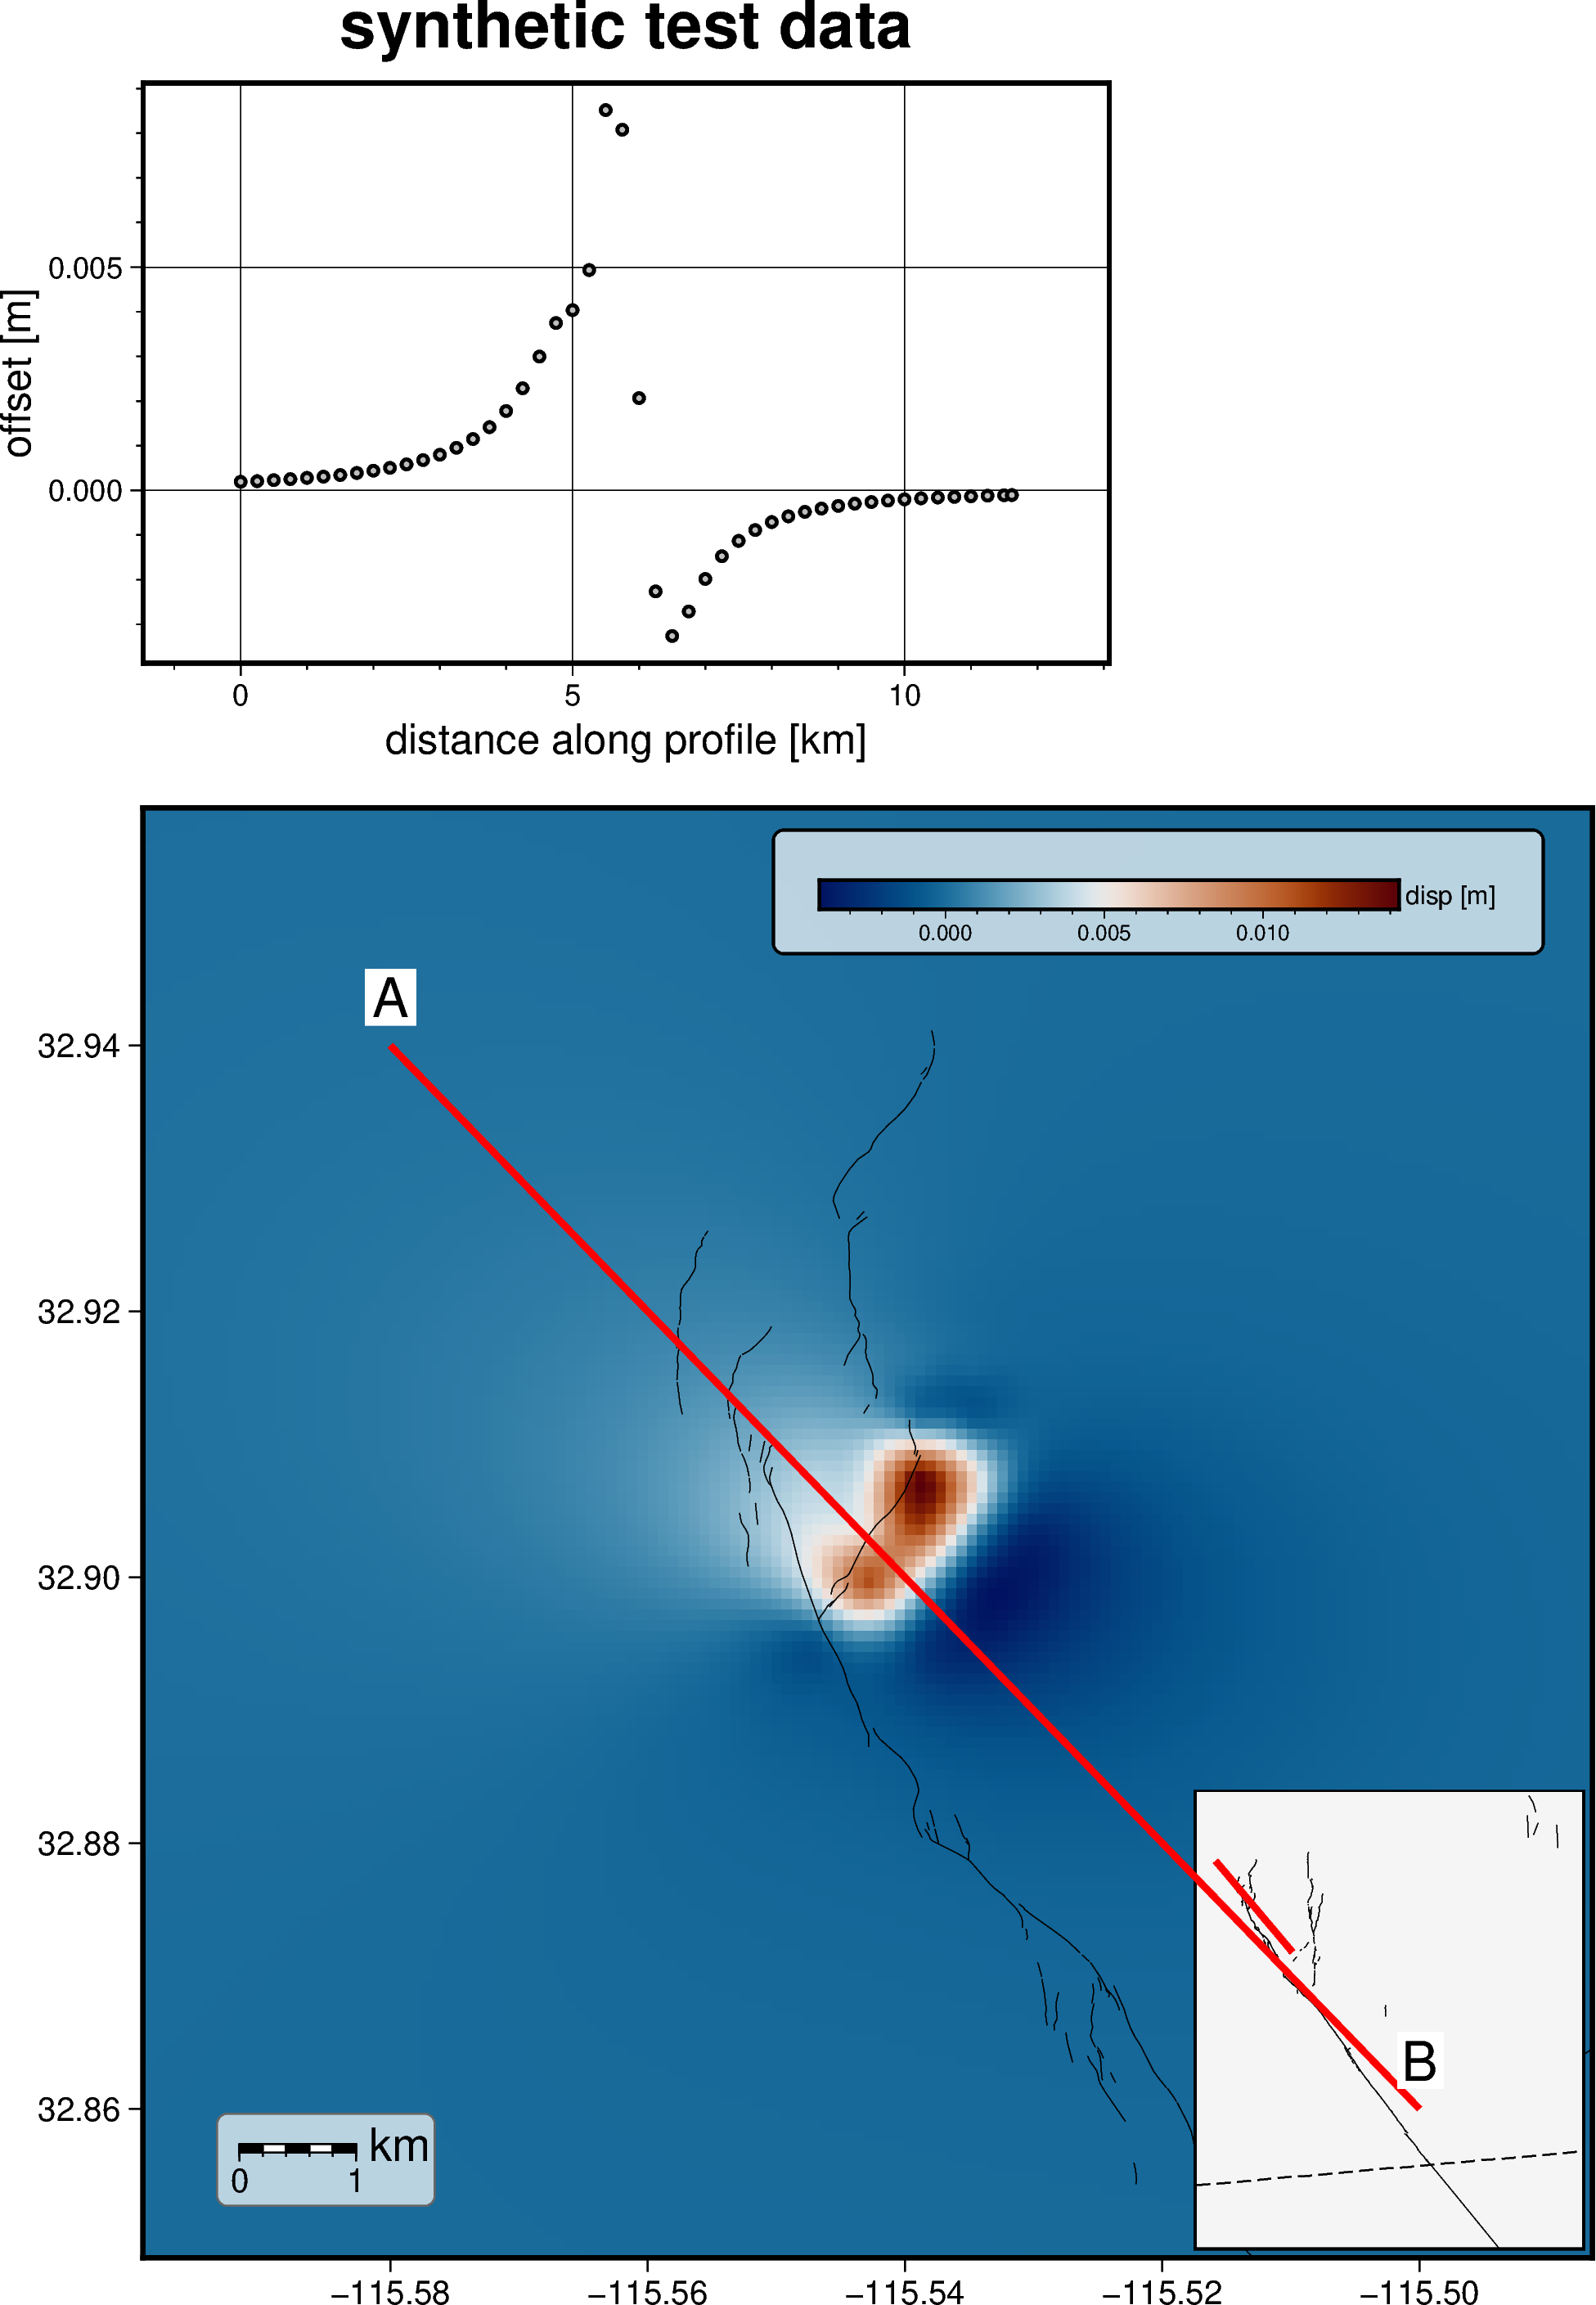

### Set-up PyMC to work with special functions 

#### i.e. these functions call elastic stresses py, specifically thru the functions "do_okada" and "do_update"

In [82]:
# CURRENTLY - there are some issues with this, so you need to run the functions in the next cell also

# utilities
from pymc_espy_utils import get_los, read_intxt, do_update, read_json

# driver
from pymc_driver import do_okada, my_loglike, LogLike, custom_dist_loglike, gauss_draw

# visualization
from pymc_visualize import plot_corner, plot_stats

In [80]:
def do_okada(slip, width, dip):
    """
    Perform Okada dislocation of a rectangular slip patch with slip, width, dip

    Parameters:
    -------
    slip: slip [m]

    width: width of rectangular slip patch (i.e. top - bottom depth) [km]

    dip: dip of rectangular slip patch [degrees]

    Returns:
    --------
    line of sight data array
    
    """
    inputs = do_update(slip[0], width[0], dip[0])

    model_disp_points = run_dc3d.compute_ll_def(inputs, params_in, disp_points)

    MyOutObject = cc.Out_object(x=[], y=[], x2d=[], y2d=[], u_disp=[], v_disp=[], w_disp=[],
                                strains=[], model_disp_points=model_disp_points,
                                zerolon=inputs.zerolon, zerolat=inputs.zerolat,
                                source_object=inputs.source_object, receiver_object=inputs.receiver_object,
                                receiver_normal=[], receiver_shear=[],
                                receiver_coulomb=[], receiver_profile=[])

    los = get_los(MyOutObject.model_disp_points)

    return los

def my_loglike(slip, width, dip, sigma, data):
    """
    Takes parameter values, sigma, and data and evaluates loglike of Gaussian distribution

    Parameters:
    -------
    slip: slip [m]

    width: width of rectangular slip patch (i.e. top - bottom depth) [km]

    dip: dip of rectangular slip patch [degrees]

    sigma: uncertainty in input data
    
    data: array of data

    Returns:
    --------
    loglike of Gaussian distribution
    
    """
    for param in (slip, width, dip, sigma, data):
        if not isinstance(param, (float, np.ndarray)):
            raise TypeError(f"Invalid input type to loglike: {type(param)}") 
    model = do_okada(slip, width, dip)
    #return -0.5 * ((data - model) / sigma) ** 2 - np.log(np.sqrt(2 * np.pi)) - np.log(sigma)
    return -(0.5/sigma**2)*np.sum((data - model)**2) #eq. 5.1 Menke textbook

class LogLike(Op):

    def make_node(self, slip, width, dip, sigma, data) -> Apply:
        slip = pt.as_tensor(slip)
        width = pt.as_tensor(width)
        dip = pt.as_tensor(dip)
        data = pt.as_tensor(data)
        sigma = pt.as_tensor(sigma)

        inputs = [slip, width, dip, sigma, data]
        outputs = [data.type()]

        return Apply(self, inputs, outputs)
    
    def perform(self, node: Apply, inputs: list[np.ndarray], outputs: list[list[None]]) -> None:
        slip, width, dip, sigma, data = inputs

        loglike_eval = my_loglike(slip, width, dip, sigma, data)

        outputs[0][0] = np.asarray(loglike_eval)

def gauss_draw(slip, width, dip, size=None):
        return np.random.Generator.random(slip, width, dip, size = size)

def custom_dist_loglike(data, slip, width, dip, sigma):
    """
    Evaluates loglike of Gaussian distribution with data and model

    Parameters:
    -------
    data: array of input data

    slip: slip [m]

    width: width of rectangular slip patch (i.e. top - bottom depth) [km]

    dip: dip of rectangular slip patch [degrees]

    sigma: uncertainty in input data

    Returns:
    --------
    loglike of Gaussian distribution
    
    """
    # data, or observed is always passed as the first input of CustomDist
    return loglike_op(slip, width, dip, sigma, data)

### Set global variables to be used in PyMC modeling (these are mostly files that Elastic Stresses Py needs)

In [84]:
# set global variables

#########################################################
# really important, set globals once before running !!  #
#########################################################
params = read_json('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/pymc_params_synth_50disp.json')
#params = read_json('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/20180105_20180117/pymc_params.json')
os.chdir(params['experiment_dir'])

inputs_orig = read_intxt(params['inputs_orig'])
params_in = PyCoulomb.configure_calc.configure_stress_calculation(params['params'])
disp_points = io_additionals.read_disp_points(params['disp_points'])
data = np.loadtxt(params['data'])

sigma = params['sigma']
#########################################################
#########################################################

Configuring with the following Params:
  -Config file: my_config_50.txt 
  -Input file: normal_fault_in.txt 
  -Disp_points_file: normal_fault_disp_50.txt 
  -Outdir: ./outputs/normal_synth_50/ 
  -Elastic moduli: 30000000000.000000, 30000000000.000000 
  -Poisson's ratio and Alpha: 0.250000, 0.666667
Reading displacement points from file normal_fault_disp_50.txt 
--> Read 50 displacement points 


### Additional set up

In [23]:
# setting up loglikelihood function
loglike_op = LogLike()

# initialize random seed
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

### Initialize PyMC model with priors

In [24]:
# initialize model
with pm.Model() as no_grad_model:
    # priors
    # slip = pm.Normal("slip", mu=params['slip_mu'], sigma=params['slip_sigma']) #mu=mean, sigma=st dev.
    # width = pm.TruncatedNormal("width", mu=params['width_mu'], sigma=params['width_sigma'], lower=params['width_lower'], upper=params['width_upper'])
    # dip = pm.TruncatedNormal("dip", mu=params['dip_mu'], sigma=params['dip_sigma'], lower=params['dip_lower'], upper=params['dip_upper'], initval=params['dip_init'])
        
    # uniform priors
    slip = pm.Uniform("slip", lower=0.01, upper=0.06, initval=0.03)
    width = pm.Uniform("width", lower=0.05, upper=1.5, initval=0.5)
    dip = pm.Uniform("dip", lower=5.0, upper=90.0, initval=80)

    # use a CustomDist with a custom logp function
    likelihood = pm.CustomDist(
        "likelihood", slip, width, dip, sigma, size=len(data), observed=data, logp=custom_dist_loglike, random=gauss_draw
    )


### Check model initialization and initial starting points

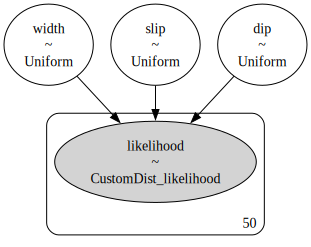

In [51]:
pm.model_to_graphviz(no_grad_model)

In [37]:
# test loglikelihood function with values used to build synthetic data

slip_true = 0.047
dip_true = 45
width_true = 0.750

test_out = loglike_op(slip_true, width_true, dip_true, sigma, data)

In [38]:
pytensor.dprint(test_out, print_type=True)

LogLike [id A] <Vector(float64, shape=(50,))>
 ├─ 0.047 [id B] <Scalar(float64, shape=())>
 ├─ 0.75 [id C] <Scalar(float32, shape=())>
 ├─ 45 [id D] <Scalar(int8, shape=())>
 ├─ [0.002] [id E] <Vector(float64, shape=(1,))>
 └─ [ 0.000184 ... .00010774] [id F] <Vector(float64, shape=(50,))>


In [39]:
# initial evaluation points
ip = no_grad_model.initial_point()
ip

{'slip_interval__': array(-0.40546511),
 'width_interval__': array(-0.7985077),
 'dip_interval__': array(2.01490302)}

In [44]:
# calculate the logp at the initial evaluation points
no_grad_model.compile_logp(vars=[likelihood], sum=True)(ip)

#if you receive an error:
#   Error! fault.rtlat is a list instead of a value, ', array([0.05])
# restart your kernel --> this works 6/17

/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/cutde/coordinators.py:77: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(


array(-15.97900885)

### Run model

In [45]:
# run model
with no_grad_model:
    step = pm.Metropolis() # specify step
    
    # Use custom number of draws to replace the HMC based defaults
    idata_no_grad = pm.sample(draws=2000, tune=1000, step=step, return_inferencedata=True)
    #idata_no_grad.extend(pm.sample_posterior_predictive(idata_no_grad, random_seed=RANDOM_SEED))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [slip]
>Metropolis: [width]
>Metropolis: [dip]


Output()

/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/cutde/coordinators.py:77: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(
/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/cutde/coordinators.py:77: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(
/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/cutde/coordinators.py:77: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(
/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/cutde/coordinators.py:77: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 36 seconds.


### Plot output model

/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/research_codes/pymc_visualize.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chains = int(pymc_model.posterior.dims['chain'])
/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/research_codes/pymc_visualize.py:34: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  draws = int(pymc_model.posterior.dims['draw'])
/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or

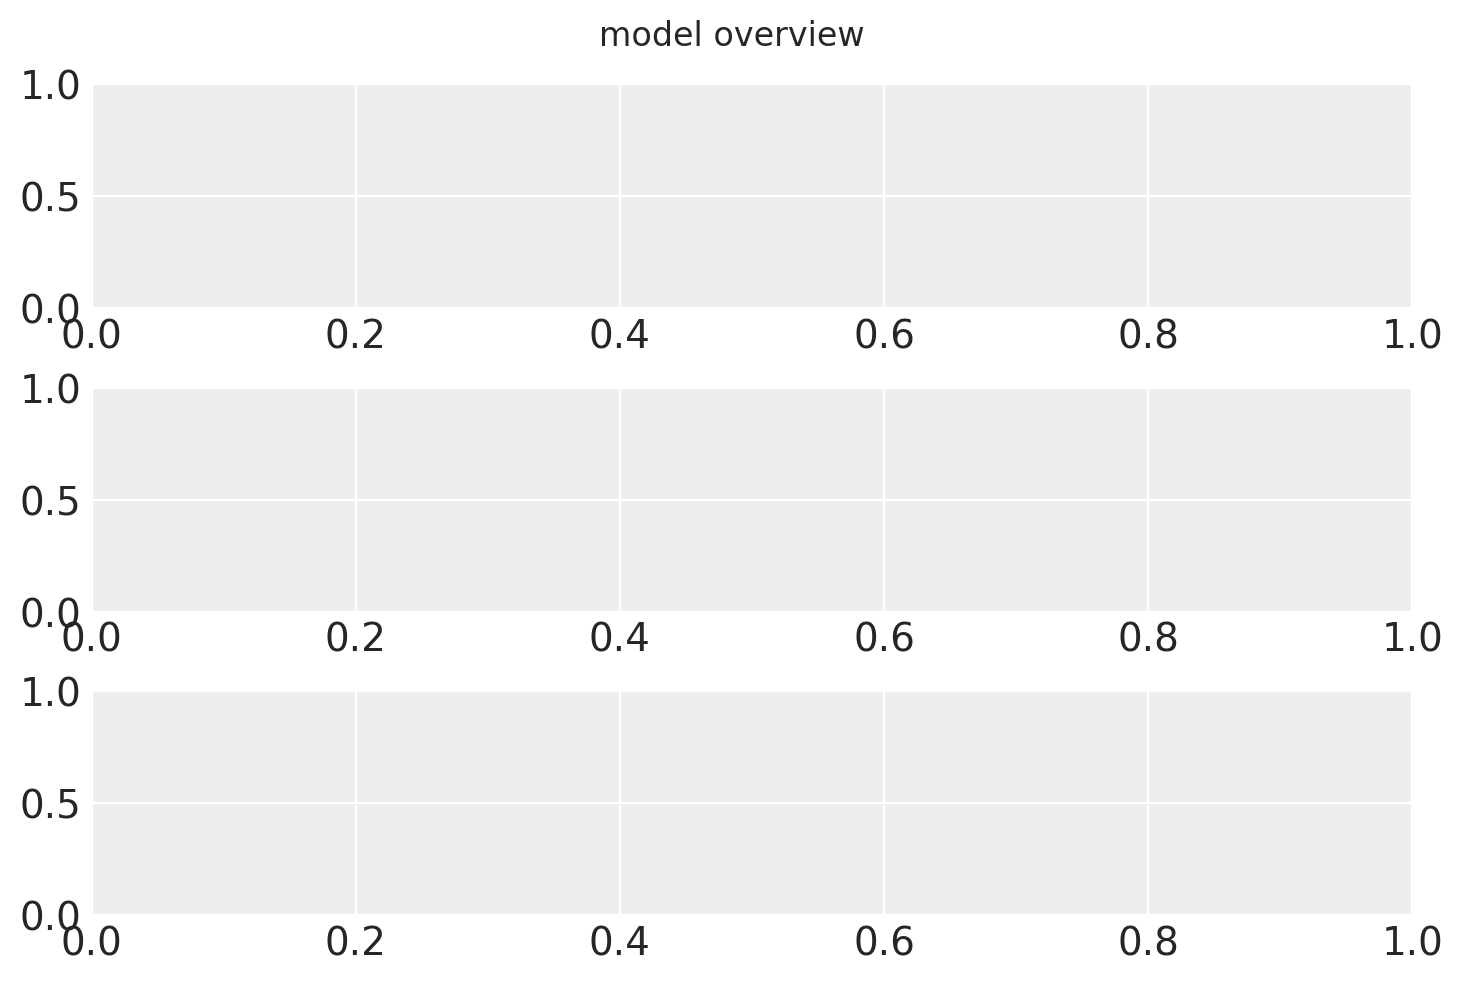

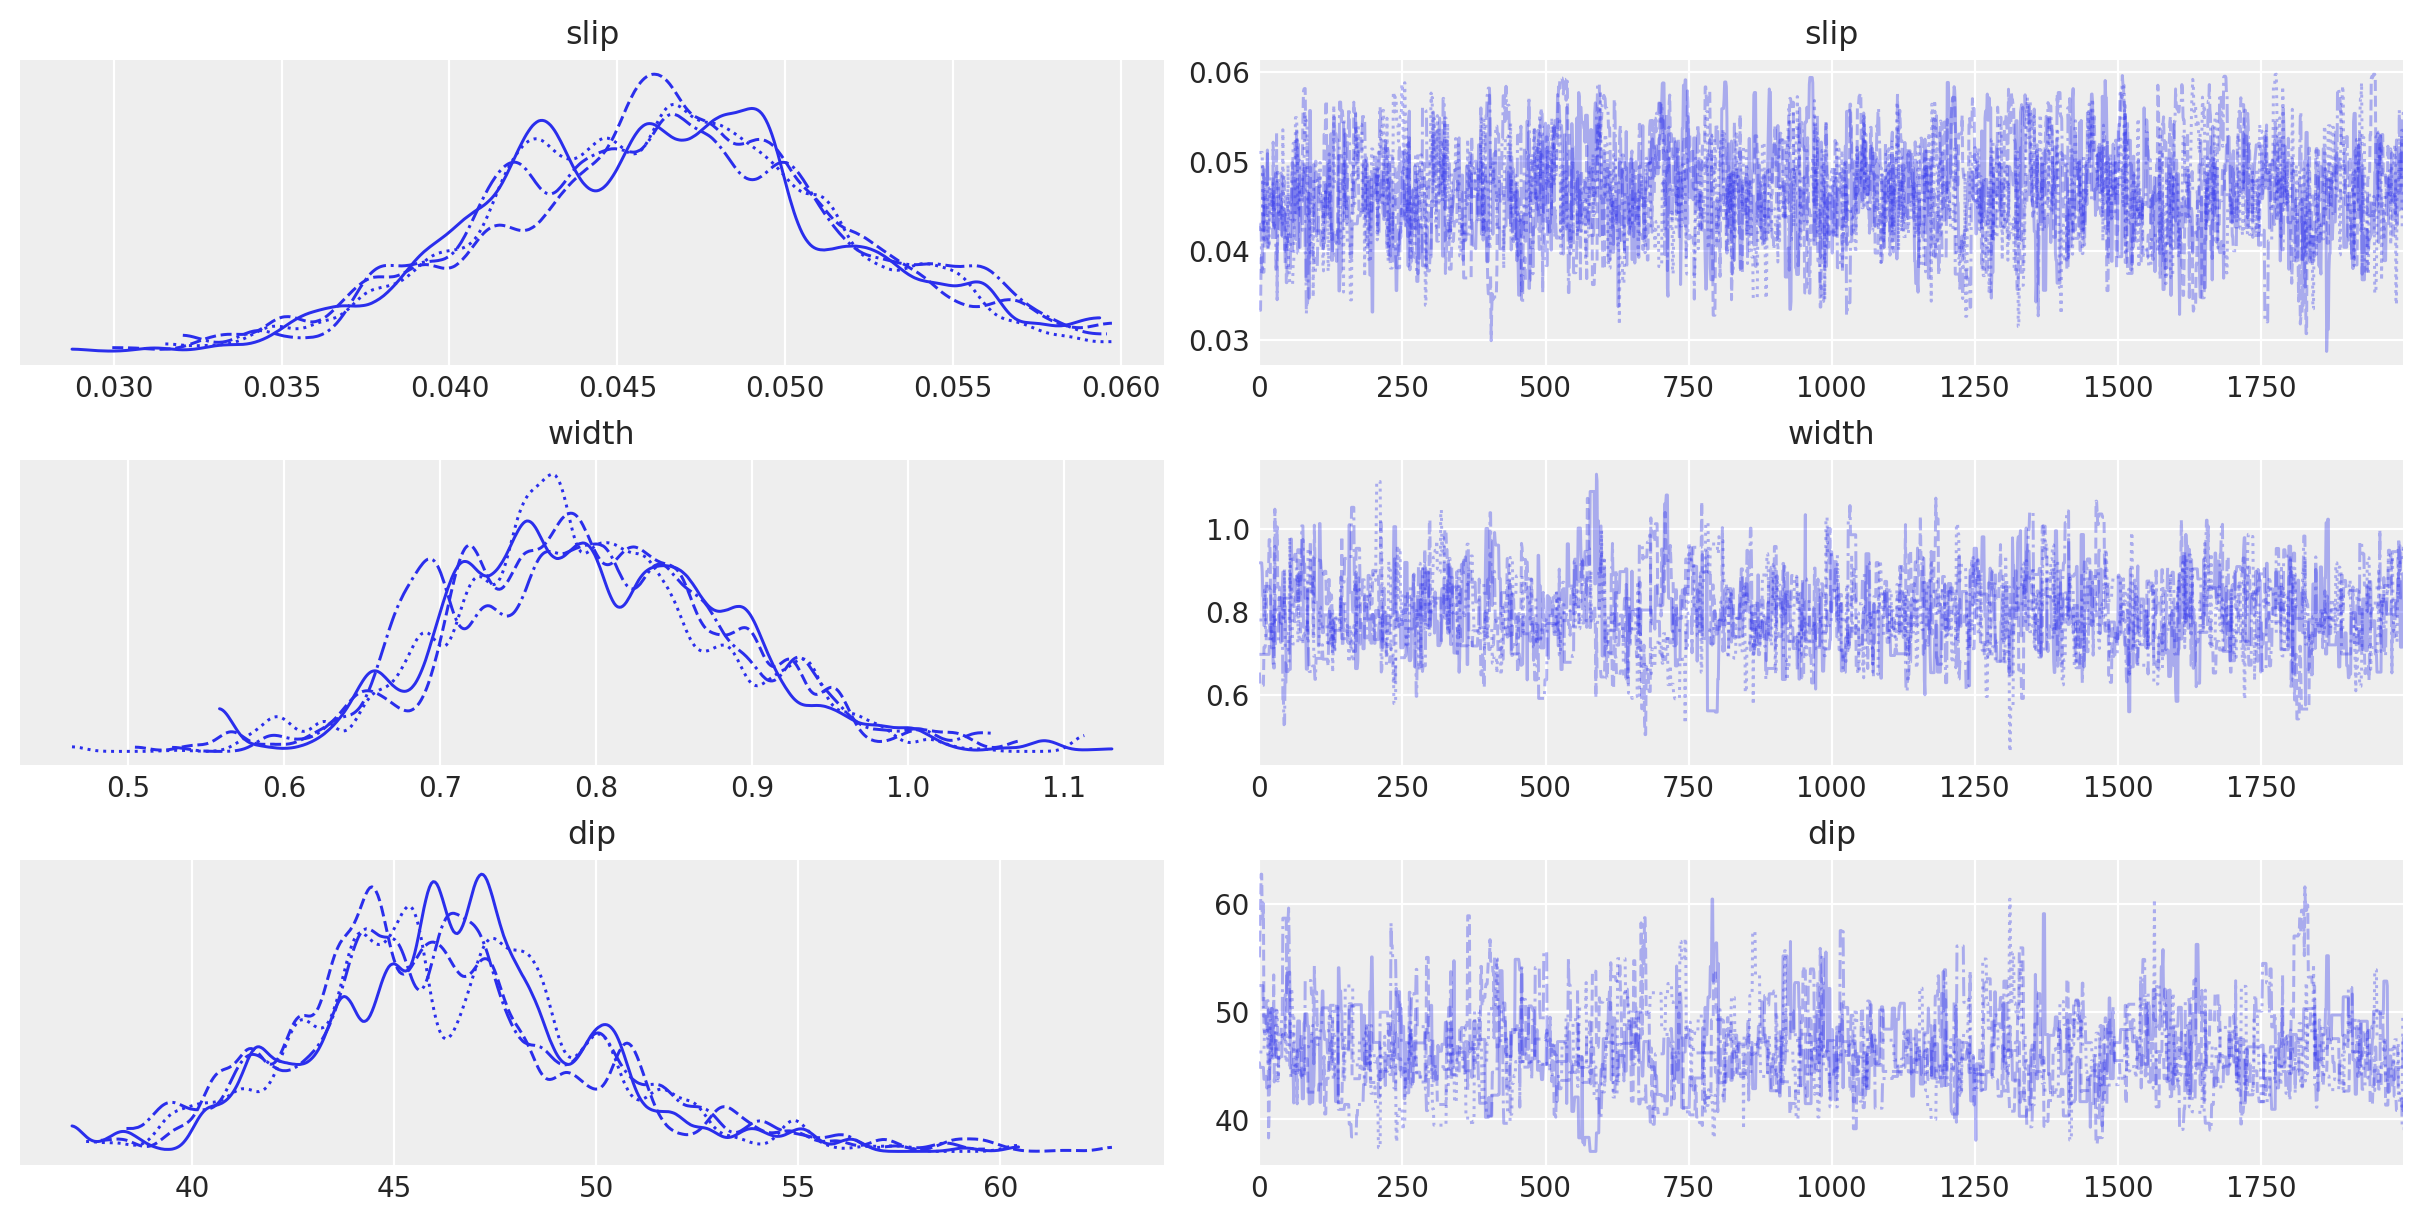

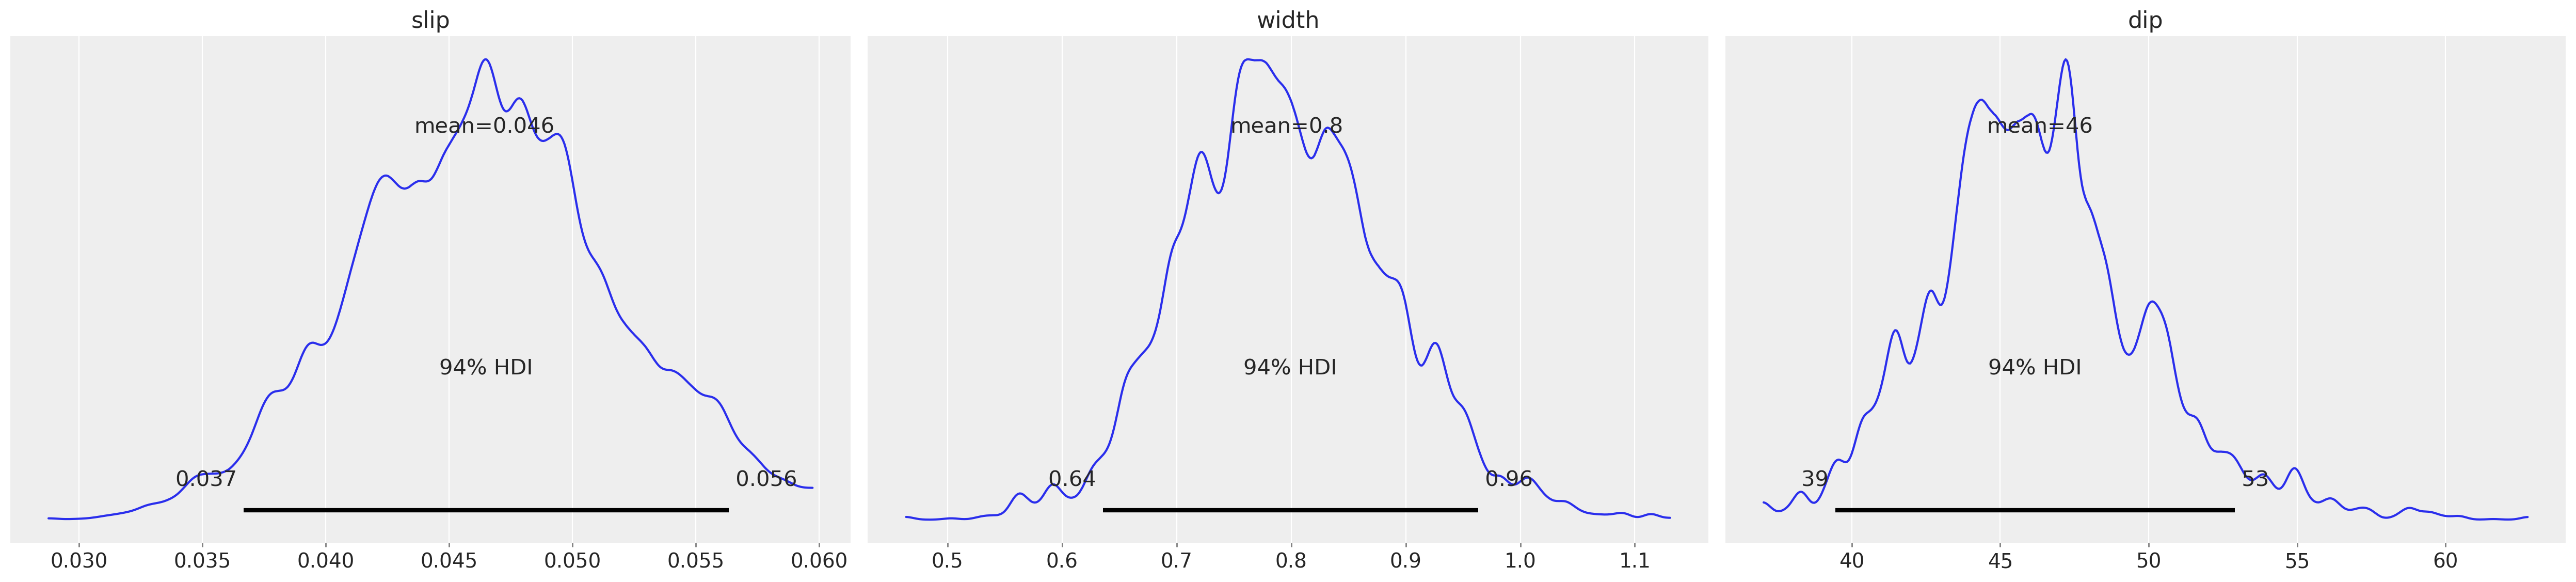

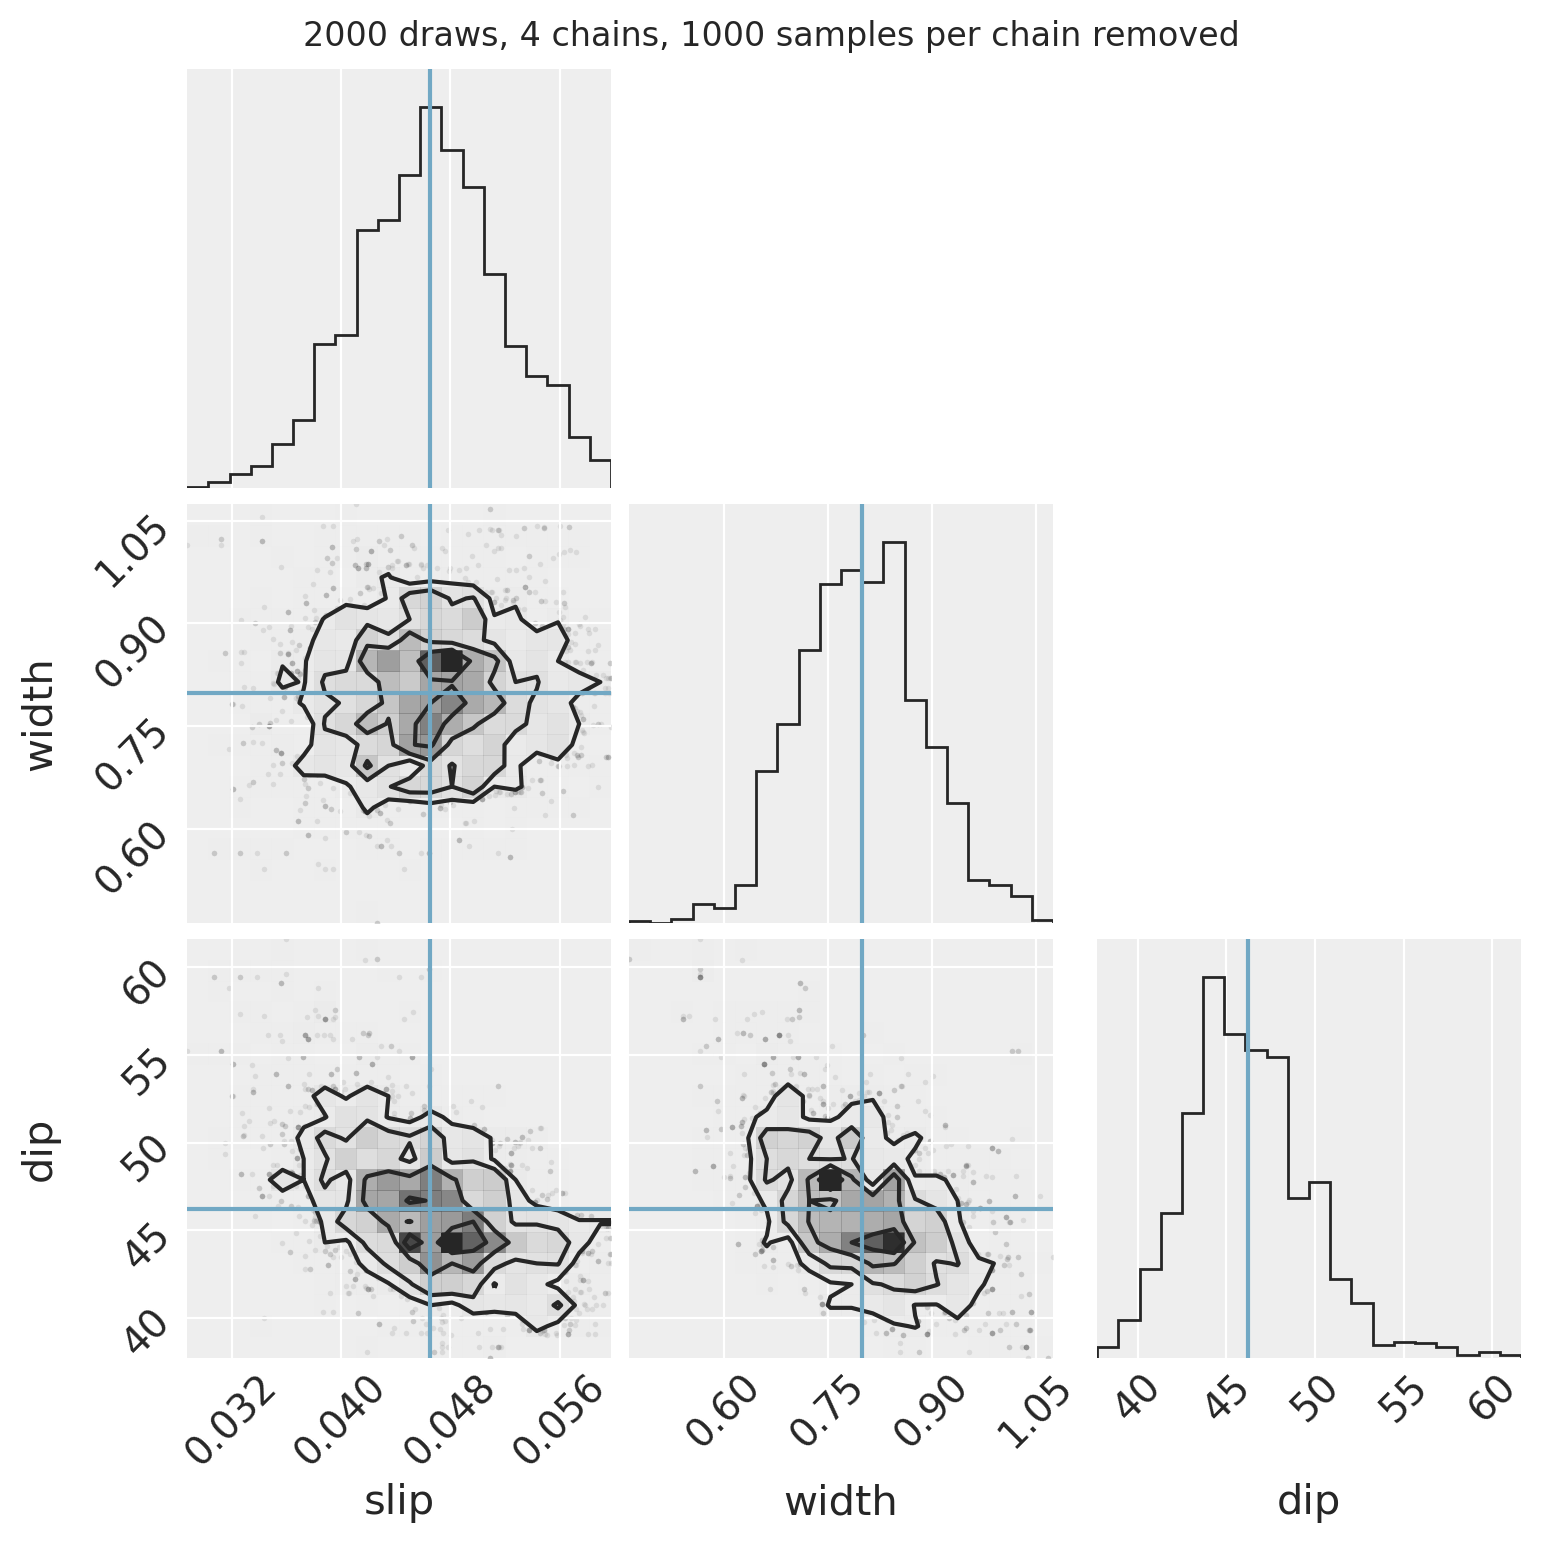

In [48]:
#plot the statistics and posterior predictions
plot_stats(idata_no_grad, round=3)

#plot corner plot
plot_corner(idata_no_grad, burn_in=True)

In [49]:
az.summary(idata_no_grad)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
slip    0.046  0.005   0.037    0.056      0.000    0.000     737.0    1292.0   
width   0.796  0.090   0.636    0.963      0.004    0.002     565.0     878.0   
dip    46.334  3.595  39.450   52.901      0.175    0.115     417.0     553.0   

       r_hat  
slip     1.0  
width    1.0  
dip      1.0

# scratch cells

In [85]:
los_pymc = do_okada(np.array([0.046]), np.array([0.75]), np.array([44.943]))
los_true = do_okada(np.array([0.047]), np.array([0.75]), np.array([45]))

#data_x = np.loadtxt('normal_fault_disp_zero_pin.txt', skiprows=0, usecols=0) #<-- data is in cm
data_x = np.loadtxt('disp_pt_2000.txt', skiprows=0, usecols=0)

#data_x = np.loadtxt('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Data/IF_longterm/creep_event_files/profiles/20180105_20180117_2.txt', skiprows=0, usecols=2)/100 #<-- data is in cm

plt.plot(data_x, los_pymc*100, c='blue', label='pymc values + okada')
plt.plot(data_x, los_true*100, c='red', label='input data values + okada')
#plt.plot(data_x, data*100, c='k', label='input data values + okada')
plt.legend()
plt.show()

NameError: name 'inputs_orig' is not defined

/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/cutde/coordinators.py:77: UserWarning: The obs_pts input array has Fortran ordering. Converting to C ordering. This may be expensive.
  warnings.warn(


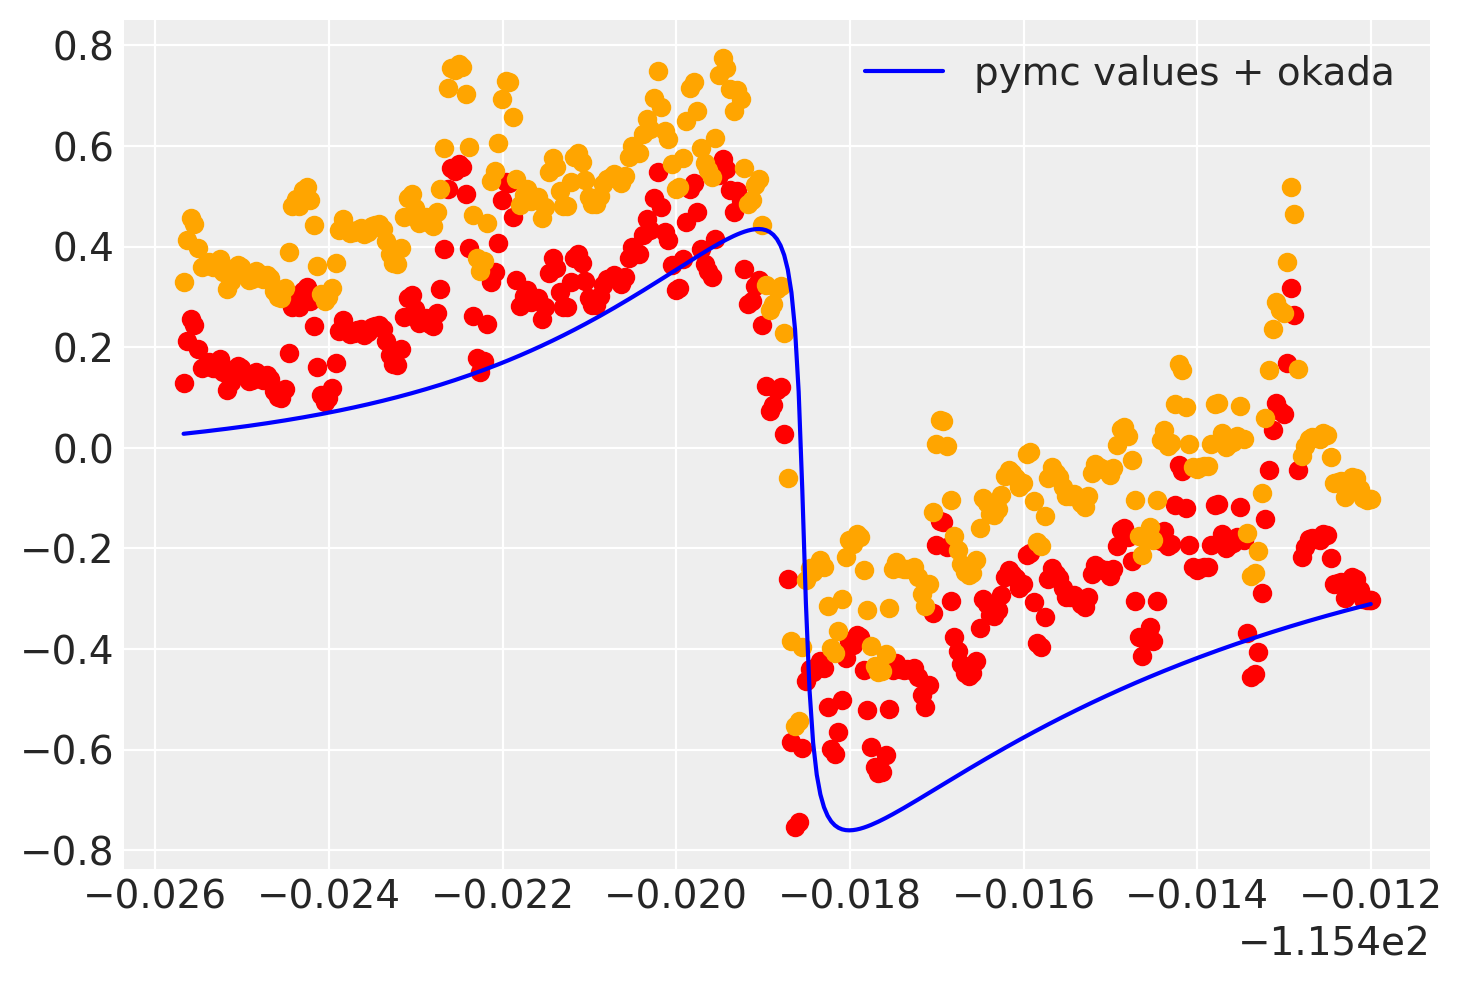

In [103]:
los_pymc = do_okada(params, np.array([0.034]), np.array([0.6]), np.array([80.024]))
#los_true = do_okada(params, np.array([0.035]), np.array([0.50]), np.array([80]))

#data_x = np.loadtxt('normal_fault_disp_zero_pin.txt', skiprows=0, usecols=0) #<-- data is in cm

data_x = np.loadtxt('disp_pt_330.txt', skiprows=0, usecols=0)

plt.scatter(data_x, data*100, c='red')
plt.scatter(data_x, data_par*100, c='orange')
#plt.plot(los_true*100, c='red', label='input data values + okada')
plt.plot(data_x, (los_pymc*100), c='blue', label='pymc values + okada')
plt.legend()
plt.show()

In [14]:
samples = az.extract(idata_no_grad, group="posterior", num_samples=10)

In [91]:
samples['depth']

<xarray.DataArray 'depth' (sample: 10)> Size: 80B
array([0.43614709, 0.23028784, 0.9066734 , 0.07008129, 0.58294436,
       0.68048407, 0.31587752, 0.5394377 , 0.91011068, 0.83300191])
Coordinates:
  * sample   (sample) object 80B MultiIndex
  * chain    (sample) int64 80B 3 2 1 0 3 0 3 1 1 3
  * draw     (sample) int64 80B 68 67 13 35 4 64 16 89 49 50

In [18]:
with no_grad_model:
    idata_no_grad.extend(pm.sample(100, tune=20, random_seed=rng))

az.plot_trace(idata_no_grad)

NotImplementedError: Cannot convert None to a tensor variable.

## Visualization checking

In [ ]:
xs = [-115.58000, 32.94000] #for 2018 normal
ys = [ -115.50000, 32.86000]

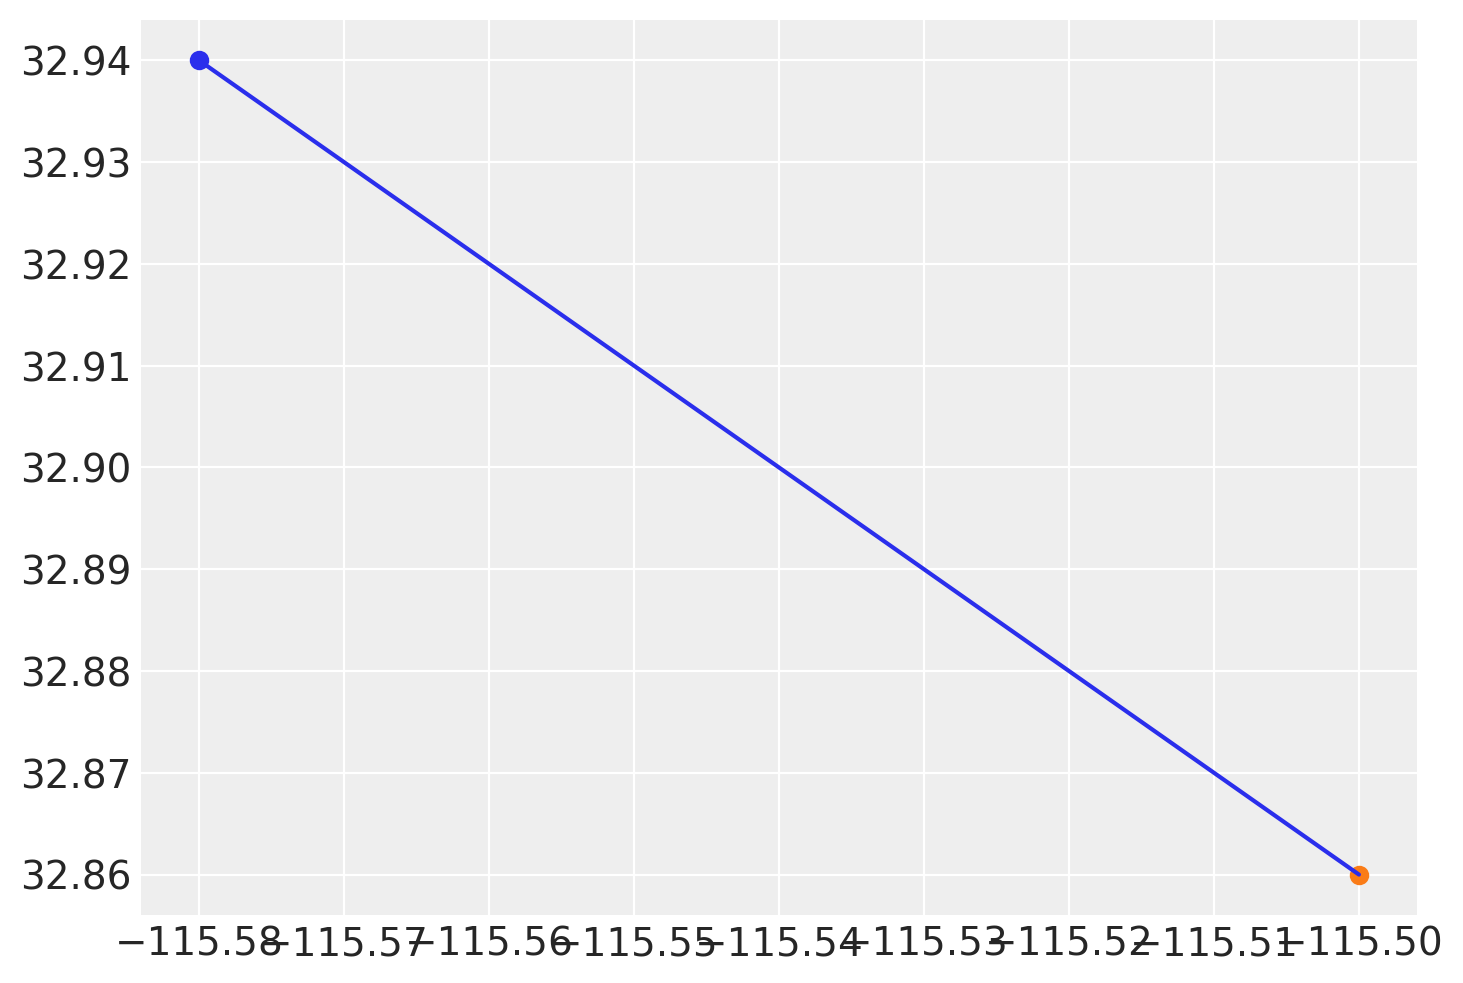

In [87]:
#x0, y0 = -115.50000, 32.86000 # These are in _pixel_ coordinates!!
#x1, y1 = -115.58000, 32.94000

x0, y0 = -115.58000, 32.94000 #for 2018 normal
x1, y1 = -115.50000, 32.86000
#length = int(np.hypot(x1-x0, y1-y0))
length = 50
x, y = np.linspace(x0, x1, length), np.linspace(y0, y1, length)

#plt.scatter(-115.50000, 32.86000)
#plt.scatter(-115.58000, 32.94000)
plt.scatter(-115.58000, 32.94000)
plt.scatter(-115.50000, 32.86000)
plt.plot(x, y)

In [88]:
with open('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/normal_fault_disp_50.txt', 'w') as file:
      for i in range(len(x)):
          file.write(f'{x[i]}\t{y[i]}\n')

In [93]:
f = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/outputs/normal_synth_50/ll_disps.txt'

e = np.loadtxt(f, usecols=2)
n = np.loadtxt(f, usecols=3)
u = np.loadtxt(f, usecols=4)
los = insar_vector_functions.def3D_into_LOS(e, n, u, 190, 36.5) * -1

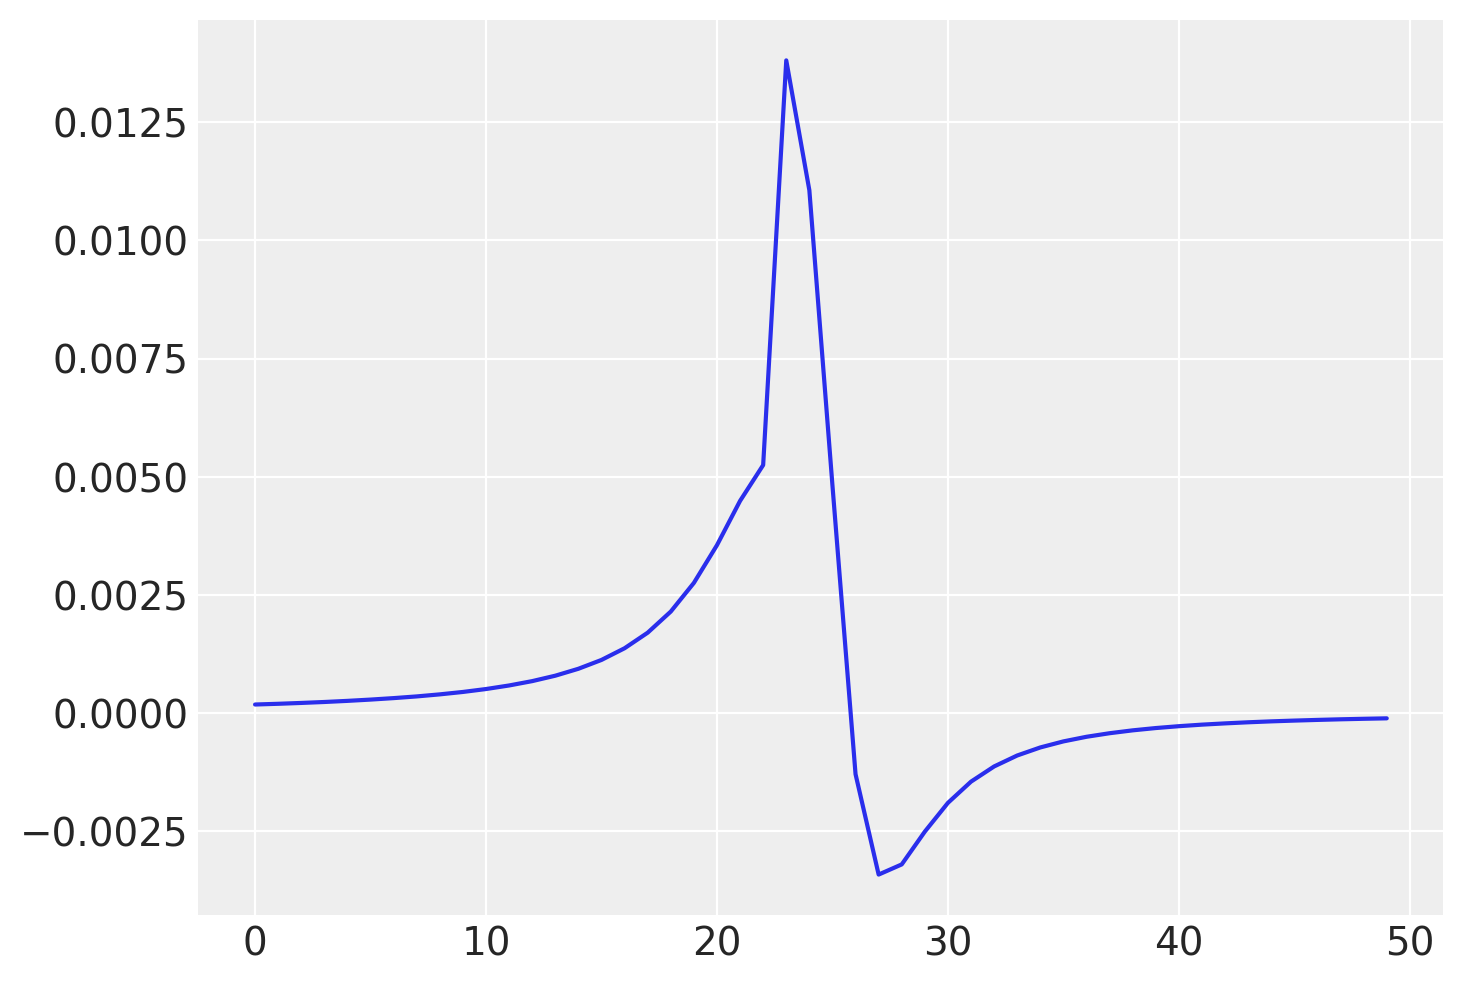

In [94]:
plt.plot(los)

In [ ]:
with open('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/normal_fault_disp_50.txt', 'w') as file:
      for i in range(len(x)):
          file.write(f'{x[i]}\t{y[i]}\n')

In [95]:
with open('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/los_data_50.txt', 'w') as file:
      for i in range(len(los)):
          file.write(f'{los[i]}\n')

In [36]:
full_array = np.stack([x, y], axis=1)
np.savetxt("/Users/mata7085/Desktop/normal_fault_disp_zero_pin.txt", full_array, delimiter=" ", fmt='%.5f')

In [79]:
x = np.loadtxt("normal_fault_los_zero_pin.txt", usecols=0)
y = np.loadtxt("normal_fault_los_zero_pin.txt", usecols=1)

with open('normal_fault_disp_zero_pin.txt', 'w') as file:
      for i in range(len(x)):
          file.write(f'{x[i]}\t{y[i]}\n')

In [76]:
full_array

array([[-115.58   ,   32.94   ],
       [-115.54922,   32.90788],
       [-115.54921,   32.90788],
       ...,
       [-115.53655,   32.89882],
       [-115.53655,   32.89881],
       [-115.5    ,   32.86   ]])

## Let's test do_okada() -- something seems wrong...

In [55]:
!elastic_stresses_driver my_config_normal.txt



Welcome to a simple forward modeling tool for calculating elastic displacements and coulomb stresses. 
Configuring with the following Params:
  -Config file: my_config_normal.txt 
  -Input file: normal_fault_in.txt 
  -Disp_points_file: normal_fault_disp_zero_farfield.txt 
  -Outdir: ./outputs/normal_synth_zeropin/ 
  -Elastic moduli: 30000000000.000000, 30000000000.000000 
  -Poisson's ratio and Alpha: 0.250000, 0.666667
Reading source and receiver fault information from file normal_fault_in.txt 
Reading displacement points from file normal_fault_disp_zero_farfield.txt 
--> Read 2002 displacement points 
Number of total sources: 1
Number of rectangular sources: 1
Moment Magnitude from Rectangular Fault Patches (assuming G=30.0GPa): 4.100248
Beginning stress calculation.
Number of sources: 1 
Number of receivers: 0 
Coefficient of friction: 0.400000
Splitting 0 receiver faults into 0 subfaults each.
/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/cutde/coordinators.py:77

In [63]:
e = np.loadtxt('normal_fault_los_zero_pin.txt', usecols=2)
x = np.loadtxt('normal_fault_los_zero_pin.txt', usecols=0)
n = np.loadtxt('normal_fault_los_zero_pin.txt', usecols=3)
u = np.loadtxt('normal_fault_los_zero_pin.txt', usecols=4)
los = insar_vector_functions.def3D_into_LOS(e, n, u, 190, 36.5) * -1

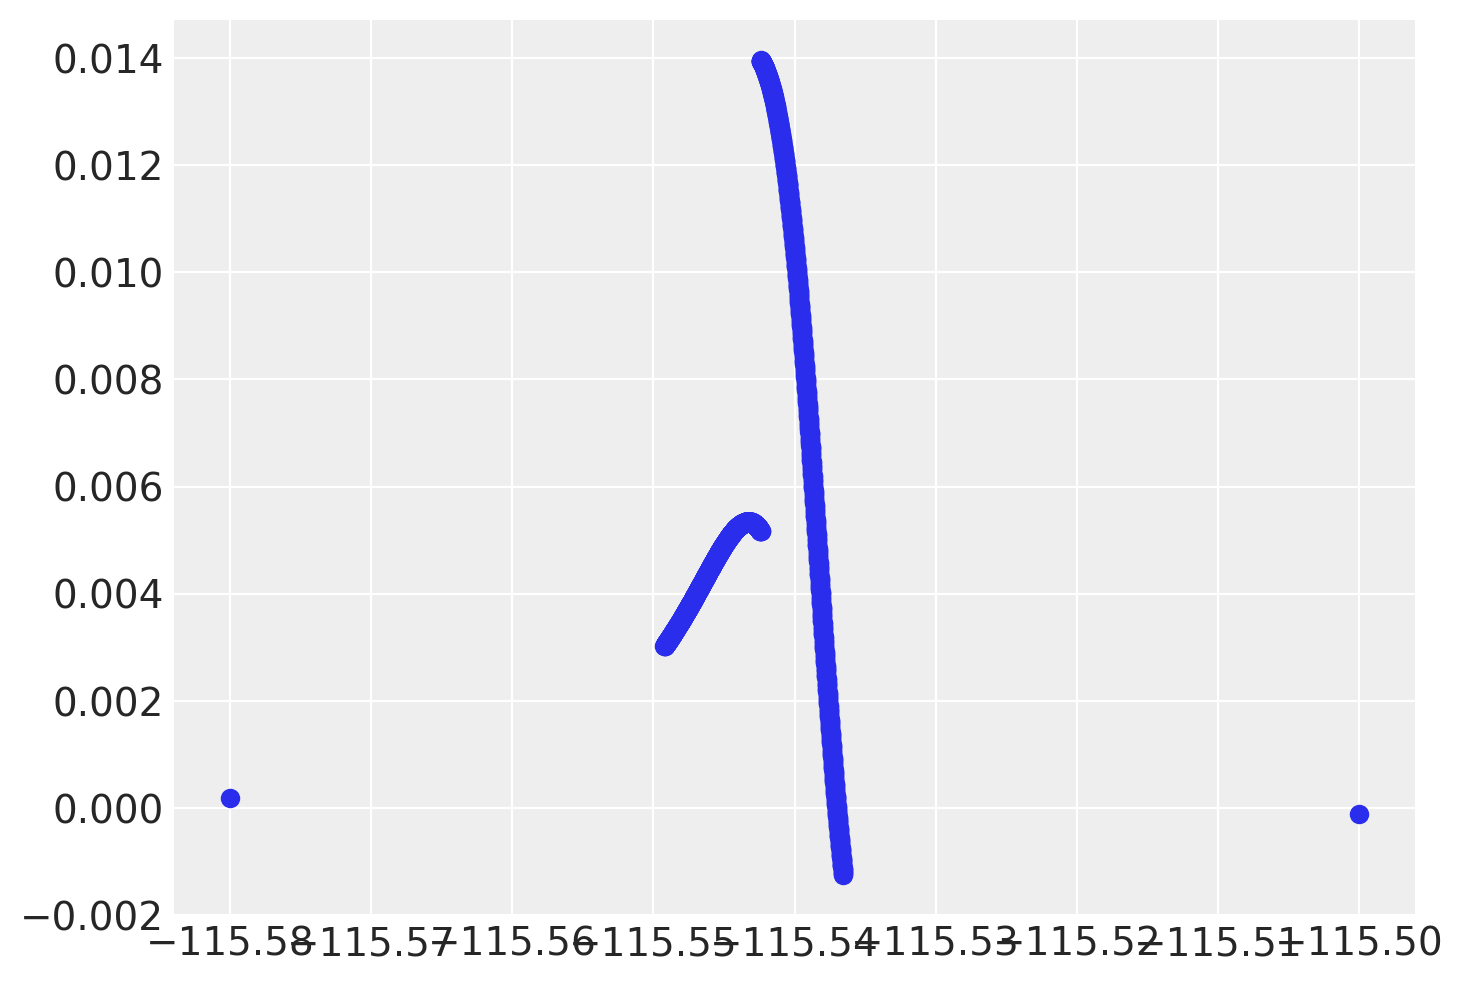

In [66]:
plt.scatter(x, los)

In [10]:
import xarray as xr
from Tectonic_Utils.read_write import netcdf_read_write
import pygmt
import pandas as pd
import json

def enu2los(grd_e, grd_n, grd_u, adj, flight_angle, incidence_angle, save=False, outpath=None):
    #if flight_angle > 1:
    #    flight_angle = np.deg2rad(flight_angle)
    #    incidence_angle = np.deg2rad(incidence_angle)
    
    n = xr.open_dataset(grd_n)
    e = xr.open_dataset(grd_e)
    u = xr.open_dataset(grd_u)

    los = insar_vector_functions.def3D_into_LOS(e, n, u, flight_angle, incidence_angle) * adj

    e.close()
    n.close()
    u.close()

    if save:
        netcdf_read_write.produce_output_netcdf(los['x'], los['y'], los['z'], 
                                                zunits='los_m',                                 
                                                netcdfname=outpath)

    return los

def sort_and_pad(subset):
    sorted = np.sort(subset)
    pad = np.sqrt( (sorted[0] - sorted[1])**2 + (sorted[3] - sorted[2])**2 )
    pad = 0.05
    if subset[0] < subset[1]:
        xs = [subset[0], subset[1]]
        ys = [subset[2], subset[3]]
    else:
        xs = [subset[1], subset[0]]
        ys = [subset[3], subset[2]]
    return xs, ys, [sorted[0] - pad, sorted[1] + pad, sorted[2] - pad, sorted[3] + pad]

In [16]:
e = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/outputs/normal_synth_50/east.grd'
n = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/outputs/normal_synth_50/north.grd'
u = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/outputs/normal_synth_50/vert.grd'

los = enu2los(e, n, u, -1, 190, 36.5, save=True, outpath='/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/outputs/normal_synth_50/los.grd')

#los_b = enu2los(e, n, u, -1, -100.5, 36.5, save=False)

#los_c = enu2los(e, n, u, 1, -100.5, 36.5, save=False)

Writing output netcdf to file /Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/outputs/normal_synth_50/los.grd 
(500, 500)


In [17]:
profile_loc = pd.read_csv('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/visualization/IF_longterm/shapefiles/profiles_across_creep_FULL.csv', header=0)
ploc_arr = np.array(profile_loc)

img = 0
#basepath = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Data/IF_longterm/creep_event_files/'
#file = '20240203_20240215_geo_phase'
#file = '20180105_20180117_geo_phase'

grid = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3/outputs/normal_synth_50/los.grd'

param_file = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Data/IF_longterm/IF_longterm_ISCEinfo/params_local.json'
f = open(param_file)
params = json.load(f)
f.close()

ERROR 1: PROJ: proj_identify: /opt/miniconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.
ERROR 1: PROJ: proj_identify: /opt/miniconda3/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.


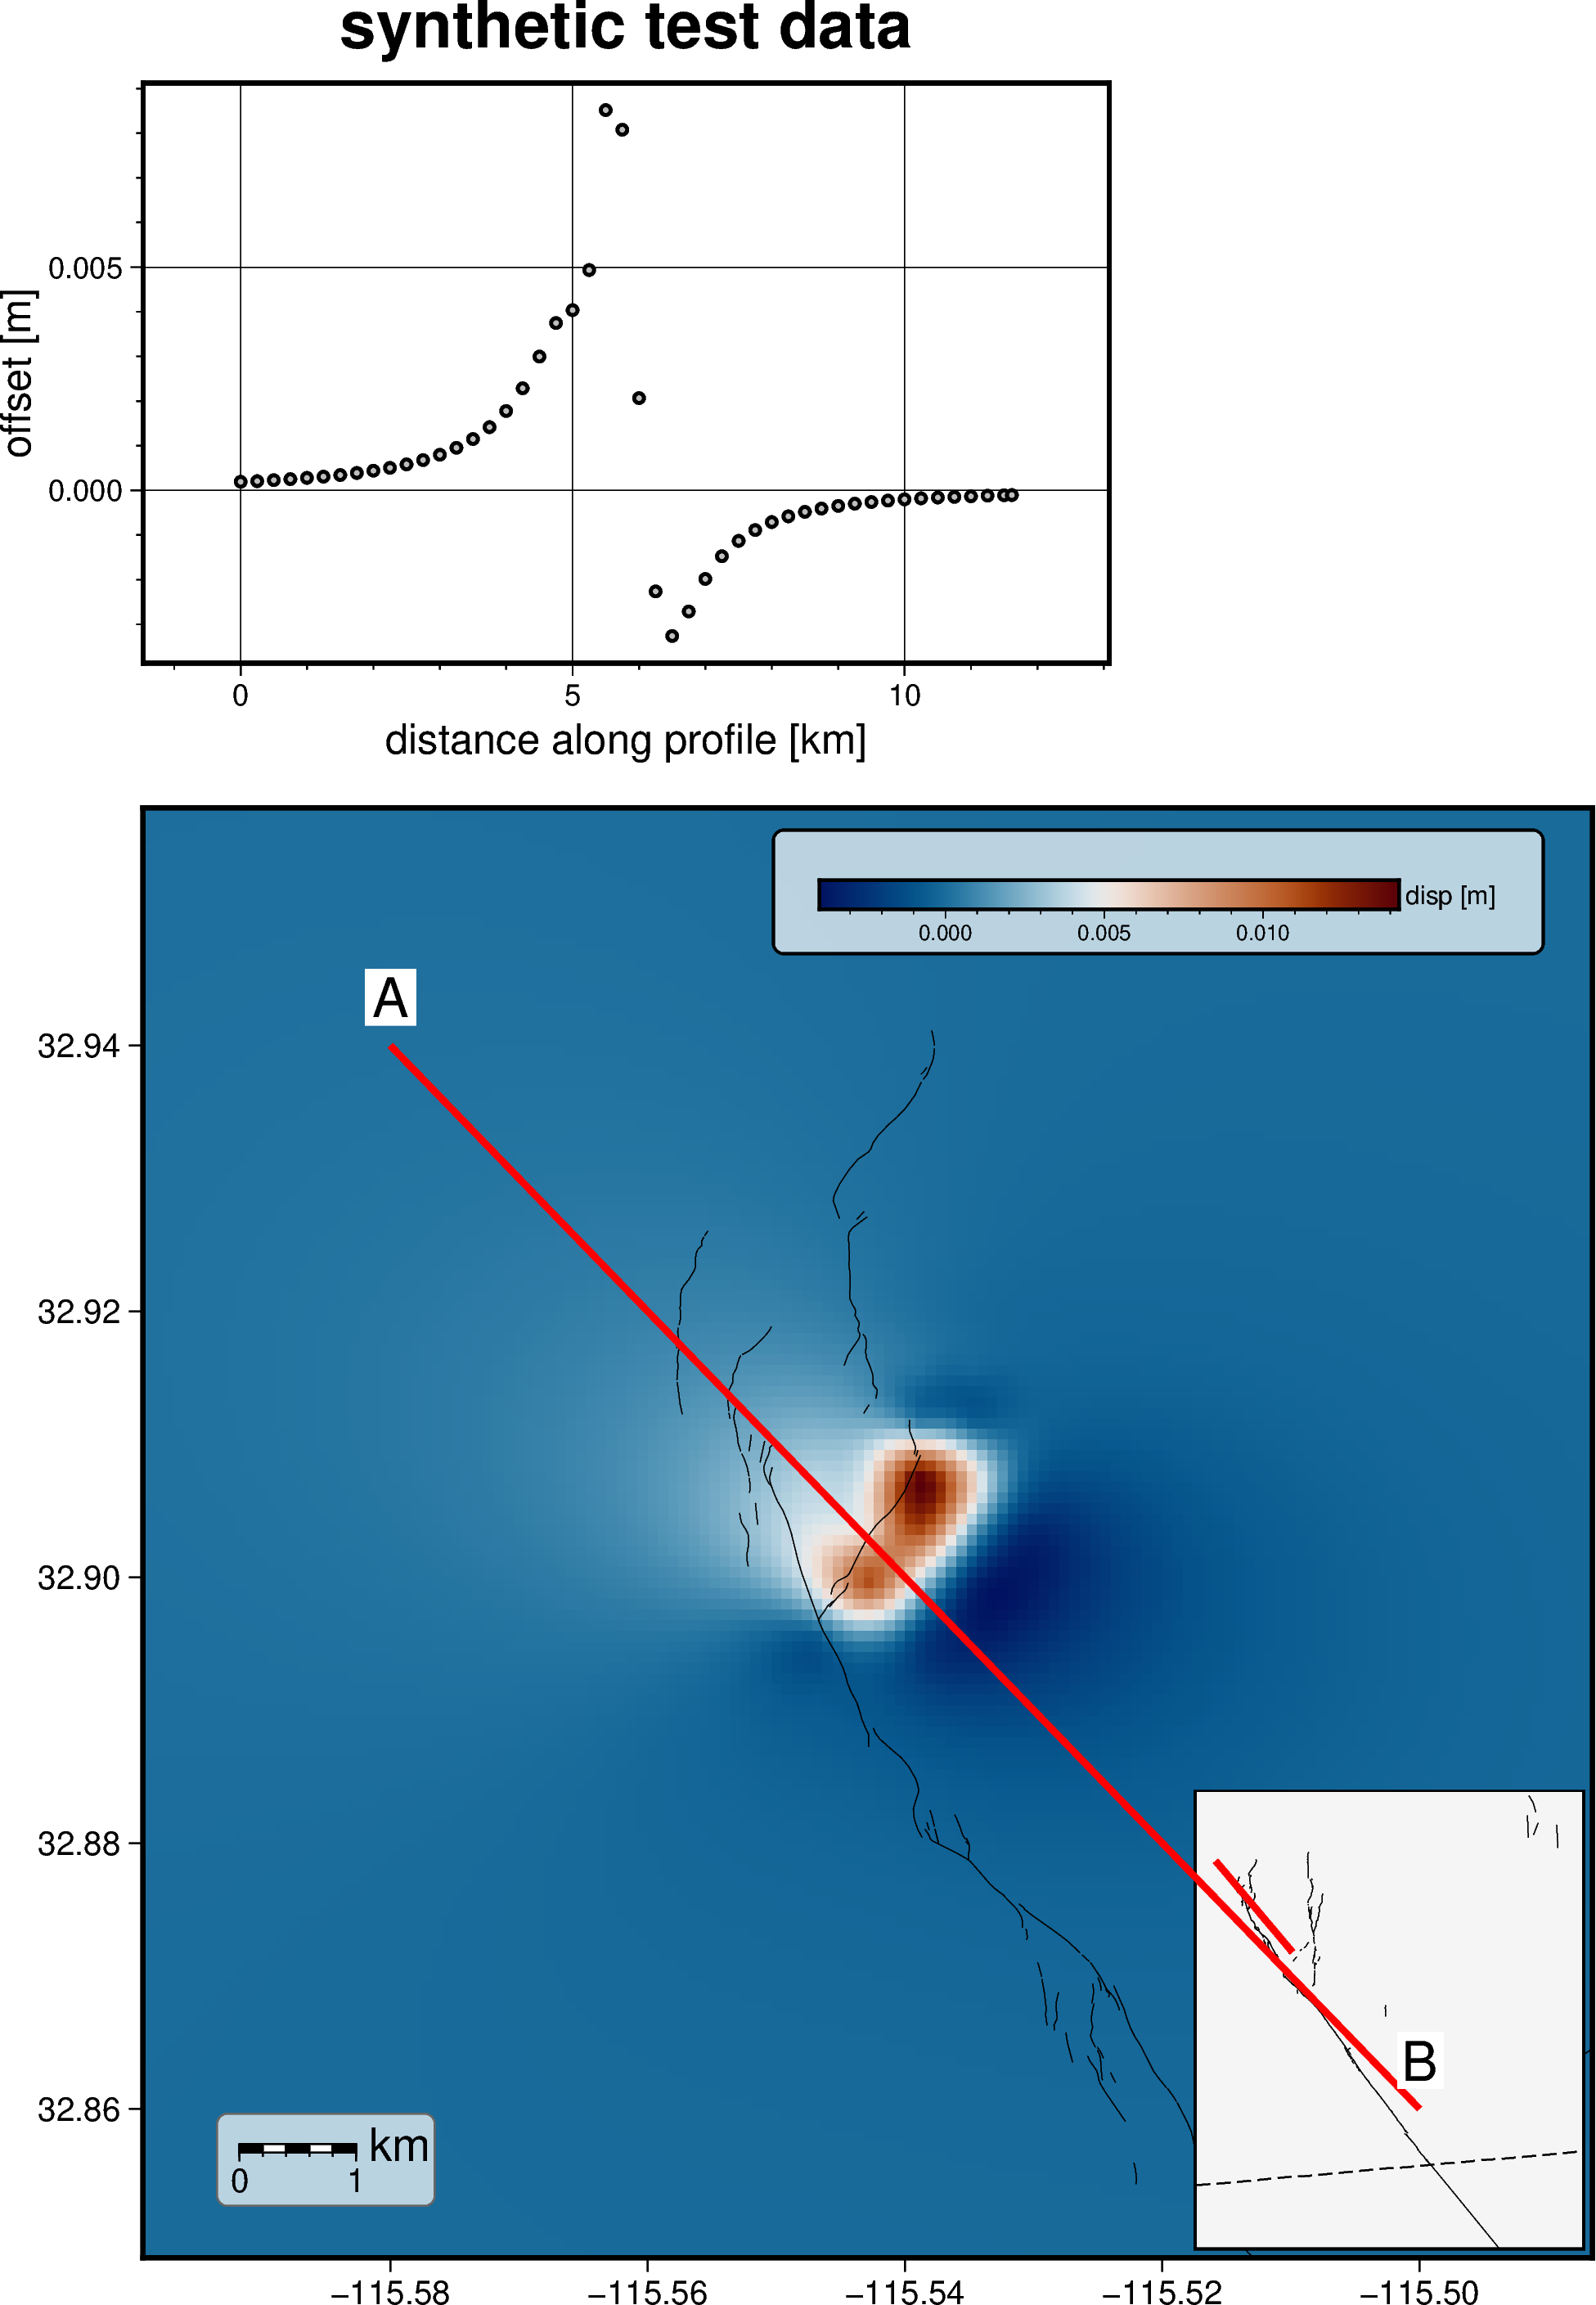

In [22]:
#-------------------#
fig = pygmt.Figure()
pygmt.config( # no alternating B&W frame
             FORMAT_GEO_MAP='ddd.xx') # decimal degrees

subset = np.sort([ploc_arr[img][5], ploc_arr[img][6], ploc_arr[img][4], ploc_arr[img][3]])
xs, ys, sorted = sort_and_pad(subset)
xs = [-115.58000, -115.50000] #for 2018 normal
ys = [32.94000, 32.86000]

out_df = pygmt.project(
    x=los['x'], 
    y=los['y'], 
    z=los['z'],
    #x=x_arr, 
    #y=y_arr, 
    #z=data_bbox,
    unit=True,
    #center=[ploc_arr[img][5], ploc_arr[img][3]],  # Start point of survey line (longitude, latitude)
    #endpoint=[ploc_arr[img][6], ploc_arr[img][4]],  # End point of survey line (longitude, latitude)
    center=[xs[0], ys[0]],
    endpoint=[xs[1], ys[1]],
    generate=0.25,  # Output data in steps of 0.005 km [unit=True]
    #width=[-0.1, 0.1],
    output_type='pandas'
    #outfile='/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Data/IF_longterm/creep_event_files/profiles/test_profile.dat'
) 

out_df = pygmt.grdtrack(grid=grid, 
                        points=out_df, newcolname="disp")

pady = np.mean(out_df.disp)
padx = np.mean(out_df.p)/4
region_padded_parx = np.sort([0-padx, max(out_df.p)+padx])
region_padded_pary = np.sort([min(out_df.disp)-pady, max(out_df.disp)+pady])
region_padded = np.concatenate((region_padded_parx, region_padded_pary)) #sometimes issues with this!!
#region_padded = [0, max(out_df.p), min(out_df.disp), max(out_df.disp)] #sometimes it's easier to just plot min/max

fig.grdimage(grid=grid, cmap='vik', frame="a", region=sorted) #"-115.420286/-115.414122/32.739045/32.744088"
fig.colorbar(
    # Place the colorbar inside the plot (lowercase "j") in the Bottom Right (BR)
    # corner with an offset ("+o") of 0.7 centimeters and 0.3 centimeters in x or y
    # directions, respectively; move the x label above the horizontal colorbar ("+ml")
    position="jTR+o2c/0.75c+h+w6c/0.3c+ml",
    # Add a box around the colobar with a fill ("+g") in "white" color and a
    # transparency ("@") of 30 % and with a 0.8-points thick, black, outline ("+p")
    box="+gwhite@30+p0.8p,black+r3p",
    # Add x and y labels ("+l")
    frame=["x+l ", "y+ldisp [m]"],
)
"""
fig.colorbar(
    # Colorbar placed outside the plot bounding box (J) at Middle Right (MR),
    # offset (+o) by 1 cm horizontally and 0 cm vertically from anchor point,
    # with a length/width (+w) of 7 cm by 0.5 cm and a box for NaN values (+n)
    position="JMR+o1c/0c+w8c/0.75c+mc",
    # Note that the label 'Elevation' is moved to the opposite side and plotted
    # vertically as a column of text using '+mc' in the position parameter
    # above
    frame=["x+l ", "y+ldisp [cm]"],
)
"""
fig.coast(
    region=sorted,
    #projection="M10c",
    #land="tan",
    #water="steelblue",
    borders="1/0.5p,black,-",
    #frame=["WSne", "a"],
    # Set the label alignment (+a) to right (r)
    map_scale="jBL+o1c/1c+c-7+w1k+f+lkm+ar", #+w1e --> 1m
    # Fill the box in white with a transparency of 30 percent, add a solid
    # outline in darkgray (gray30) with a thickness of 0.5 points, and use
    # rounded edges with a radius of 3 points
    box="+gwhite@30+p0.5p,gray40,solid+r3p",
)
fig.plot(data=params["qfaults_shp"])

with fig.inset(
    position="jBR+o0.1c",
    box="+pblack",
    region=params['extent'],
    projection="U11N/4c"
):
    # Highlight the Japan area in "lightbrown"
    # and draw its outline with a pen of "0.2p".
    fig.coast(
    # Set the projection to Mercator, and the plot width to 10 centimeters
    projection="M4c",
    # Set the region of the plot
    region=params['extent'],
    # Set the frame of the plot, here annotations and major ticks
    frame=["WSne", "a"],
    # Set the color of the land to "darkgreen"
    land="whitesmoke",
    # Set the color of the water to "lightblue"
    water="lightblue",
    # Draw national borders with a 1-point black line
    borders="1/0.5p,black,-",

)
    # Plot a rectangle ("r") in the inset map to show the area of the main
    # figure. "+s" means that the first two columns are the longitude and
    # latitude of the bottom left corner of the rectangle, and the last two
    # columns the longitude and latitude of the upper right corner.
    fig.plot(data=params["qfaults_shp"])
    fig.plot(
        #x=[ploc_arr[img][5], ploc_arr[img][6]],
        #y=[ploc_arr[img][3], ploc_arr[img][4]],  # Latitude in degrees North
        x=xs,
        y=ys,
        # Draw a 2-points thick, red, dashed line for the survey line
        pen="2p,red,solid")
    rectangle = [region_padded]
    fig.plot(data=rectangle, style="r+s", pen="2p,blue")
    #fig.text(text="US", x=-115.62, y=32.66, angle=5)
    #fig.text(text="MEX", x=-115.62, y=32.648, angle=5)

fig.plot(
        #x=[ploc_arr[img][5], ploc_arr[img][6]],
        #y=[ploc_arr[img][3], ploc_arr[img][4]],  # Latitude in degrees North
    x=xs,
    y=ys,
        # Draw a 2-points thick, red, dashed line for the survey line
    pen="2p,red,solid")

    # Add labels "A" and "B" for the start and end points of the survey line
fig.text(
        #x=[ploc_arr[img][5], ploc_arr[img][6]],
        #y=[ploc_arr[img][3], ploc_arr[img][4]],
    x=xs,
    y=ys,
    text=["A", "B"],
    offset="0c/0.5c",  # Move text 0.2 centimeters up (y direction)
    font="16p",  # Use a font size of 15 points
    fill="white"
    )

#---------------

fig.shift_origin(yshift="h+1.5c")

#head, tail = os.path.split(grid)
#title = str("_".join(tail.split('_')[0:2]))
title = 'synthetic test data'

fig.basemap(
    projection="X10/6",
    region=region_padded,
    frame=[f'wsne+t{title}']
)

fig.plot(
    x=out_df.p,
    y=out_df.disp,
    fill="gray",  # Fill the polygon in "gray"
    # Draw a 1-point thick, black, solid outline
    frame=["xafg+ldistance along profile [km]",
           "yafg+loffset [m]"],
    style='c0.1c',
    pen=1,  # Force closed polygon
)
fig.show()

In [85]:
los = np.array(out_df['disp'])
lon = np.array(out_df['r'])
los

array([ 0.00019061,  0.00020802,  0.00022828,  0.00025127,  0.00027767,
        0.00030875,  0.00034556,  0.00038904,  0.00044073,  0.00050365,
        0.00058088,  0.00067639,  0.00079661,  0.00095102,  0.00115219,
        0.00141748,  0.00177571,  0.00228606,  0.00299693,  0.00374679,
        0.00403834,  0.00493238,  0.00851638,  0.00807871,  0.00206504,
       -0.00226141, -0.00326252, -0.00271264, -0.00198428, -0.00147397,
       -0.00113073, -0.00088742, -0.00071117, -0.00058061, -0.00048185,
       -0.00040585, -0.00034628, -0.00029862, -0.00025989, -0.00022843,
       -0.0002024 , -0.00018004, -0.00016131, -0.00014542, -0.00013148,
       -0.00011941, -0.00010928, -0.00010512])

In [49]:
np.savetxt("/Users/mata7085/Desktop/normal_fault_los_zero_pinned.txt", full, fmt='%.8f')

In [86]:
rootdir = "/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3"

with open(os.path.join(rootdir, 'los_data_47.txt'), 'w') as file:
      for i in range(len(los)):
          file.write(f'{los[i]*100}\n')

with open(os.path.join(rootdir, 'normal_fault_disp_47.txt'), 'w') as file:
      for i in range(len(lon)):
          file.write(f'{lon[i]}\n')

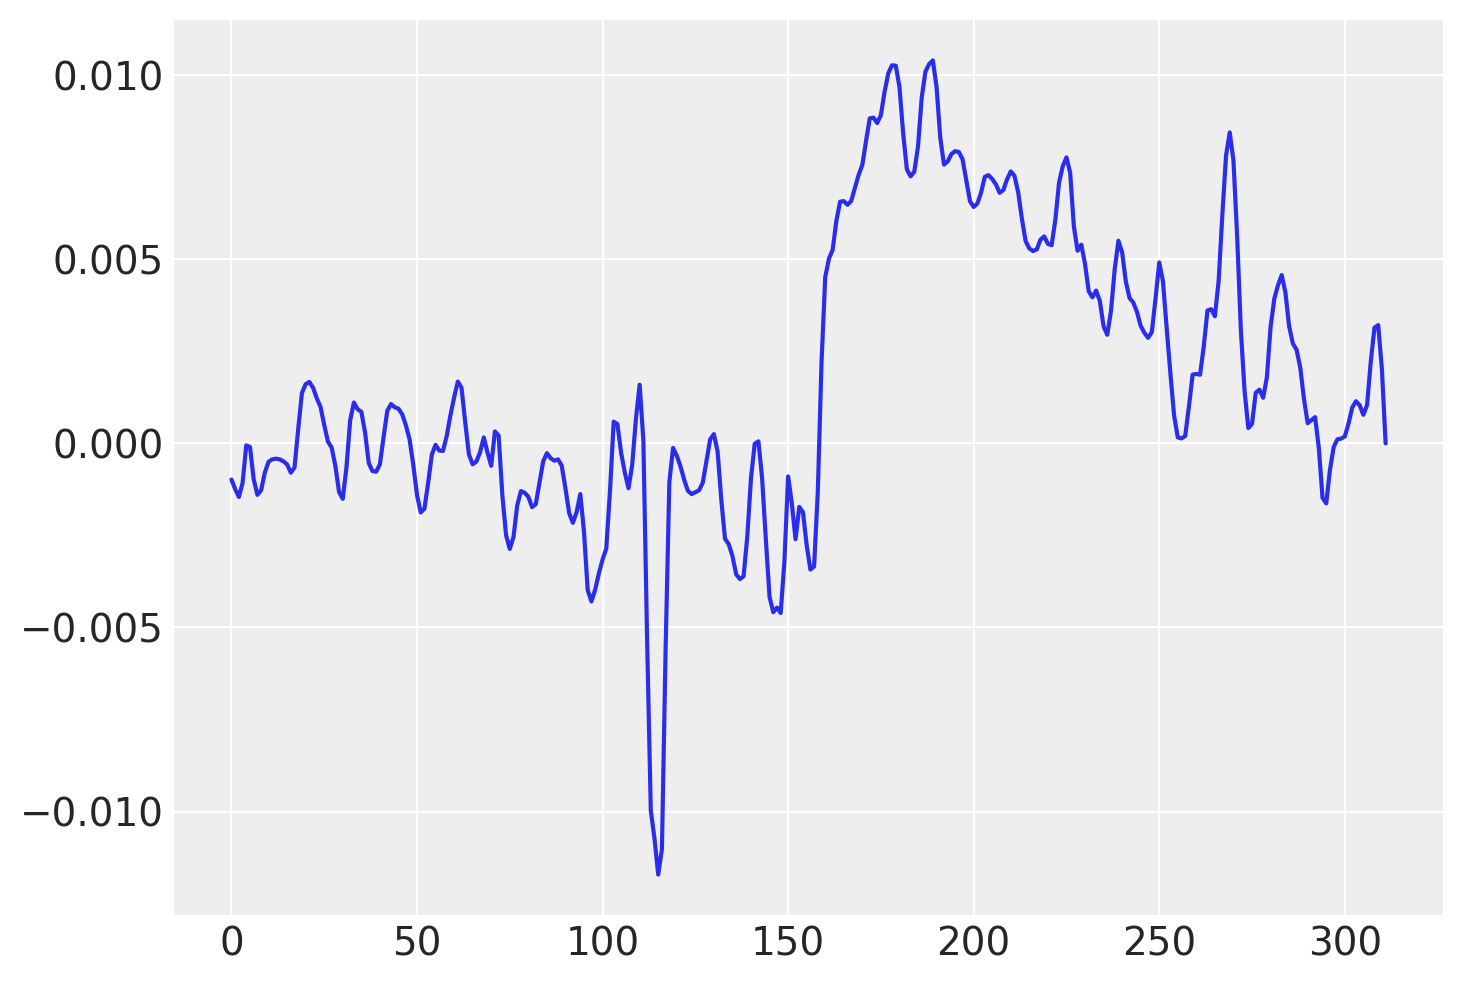

In [77]:
los_2 = np.loadtxt('/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Data/IF_longterm/creep_event_files/profiles/20240203_20240215_16.txt', skiprows=0, usecols=3)/100 #<-- data is in cm

plt.plot(los_2)

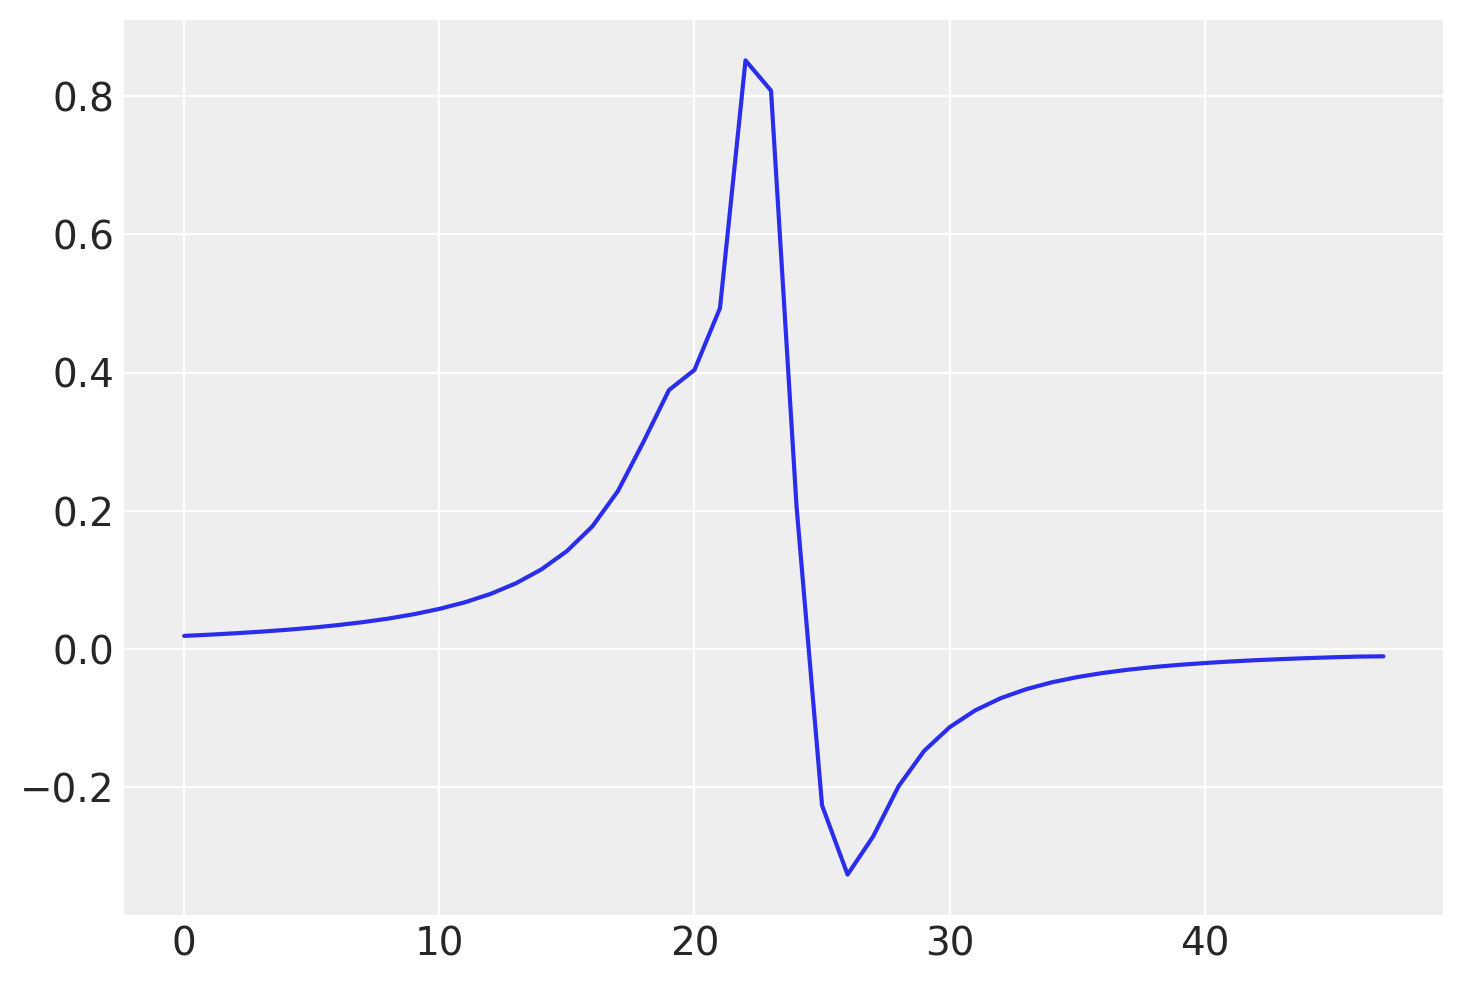

In [84]:
plt.plot(los*100)

## Testing PyMC, Arviz packages

In [9]:
import os
from datetime import datetime
import json

import pymc as pm

In [2]:
experiment_dir = "/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3"
json_outfile_name = 'pymc_params_synth_tight'

#for actual profile data, I need:
# - geo_los.rdr
# - {filename}.cor
# - {filename}.int
# - profile lat/lon

param_dict = {"experiment_dir": '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/test3',
              "inputs_orig": 'normal_fault_in.txt',
              "params": 'my_config_normal.txt',
              "disp_points": 'normal_fault_disp.txt',
              "data": 'los_data_2000.txt',
              "slip_mu": [0.047],
              "slip_sigma": [0.005],
              "width_mu": [0.75],
              "width_sigma": [0.05],
              "width_upper": [0.85],
              "width_lower": [0.65],
              "dip_mu": [45],
              "dip_sigma": [1],
              "dip_upper": [60],
              "dip_lower": [30],
              "dip_init": [45],
              "sigma": [0.2]
              }
    
with open(os.path.join(experiment_dir, json_outfile_name + '.json'), 'w', encoding='utf-8') as f:
    json.dump(param_dict, f, ensure_ascii=False, indent=4)

In [100]:
los = "/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/20180105_20180117/20180105_20180117_2.txt"

root = '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/20180105_20180117/'

arr = np.loadtxt(los, usecols=3)

arr_m = arr / 100

with open(os.path.join(root, 'los_data_330.txt'), 'w') as file:
      for i in range(len(arr_m)):
          file.write(f'{arr_m[i]}\n')

In [103]:
experiment_dir = "/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/20180105_20180117"
json_outfile_name = 'pymc_params'

#for actual profile data, I need:
# - geo_los.rdr
# - {filename}.cor
# - {filename}.int
# - profile lat/lon

param_dict = {"experiment_dir": '/Users/mata7085/Library/CloudStorage/OneDrive-UCB-O365/Documents/IF_longterm/codes/experiment2/pymc_tests/20180105_20180117',
              "inputs_orig": 'in.txt',
              "params": 'my_config.txt',
              "disp_points": 'disp_pt_330.txt',
              "data": 'los_data_330.txt',
              "slip_mu": [0.04],
              "slip_sigma": [0.005],
              "width_mu": [1],
              "width_sigma": [0.1],
              "width_upper": [2.5],
              "width_lower": [0.25],
              "dip_mu": [45],
              "dip_sigma": [5],
              "dip_upper": [90],
              "dip_lower": [0],
              "dip_init": [45],
              "sigma": [0.4]
              }
    
with open(os.path.join(experiment_dir, json_outfile_name + '.json'), 'w', encoding='utf-8') as f:
    json.dump(param_dict, f, ensure_ascii=False, indent=4)

In [101]:
2.25/2

1.125

In [3]:
print('\n'.join(m for m in dir(pm.step_methods) if m[0].isupper()))

BinaryGibbsMetropolis
BinaryMetropolis
BlockedStep
CategoricalGibbsMetropolis
CauchyProposal
CompoundStep
DEMetropolis
DEMetropolisZ
HamiltonianMC
LaplaceProposal
Metropolis
MultivariateNormalProposal
NUTS
NormalProposal
PoissonProposal
STEP_METHODS
Slice
UniformProposal


In [13]:
import corner

In [11]:
idata_sel = idata_no_grad.sel(draw=slice(200, None)) #remove first x samples from all the chains and all InferenceData groups with draws

/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


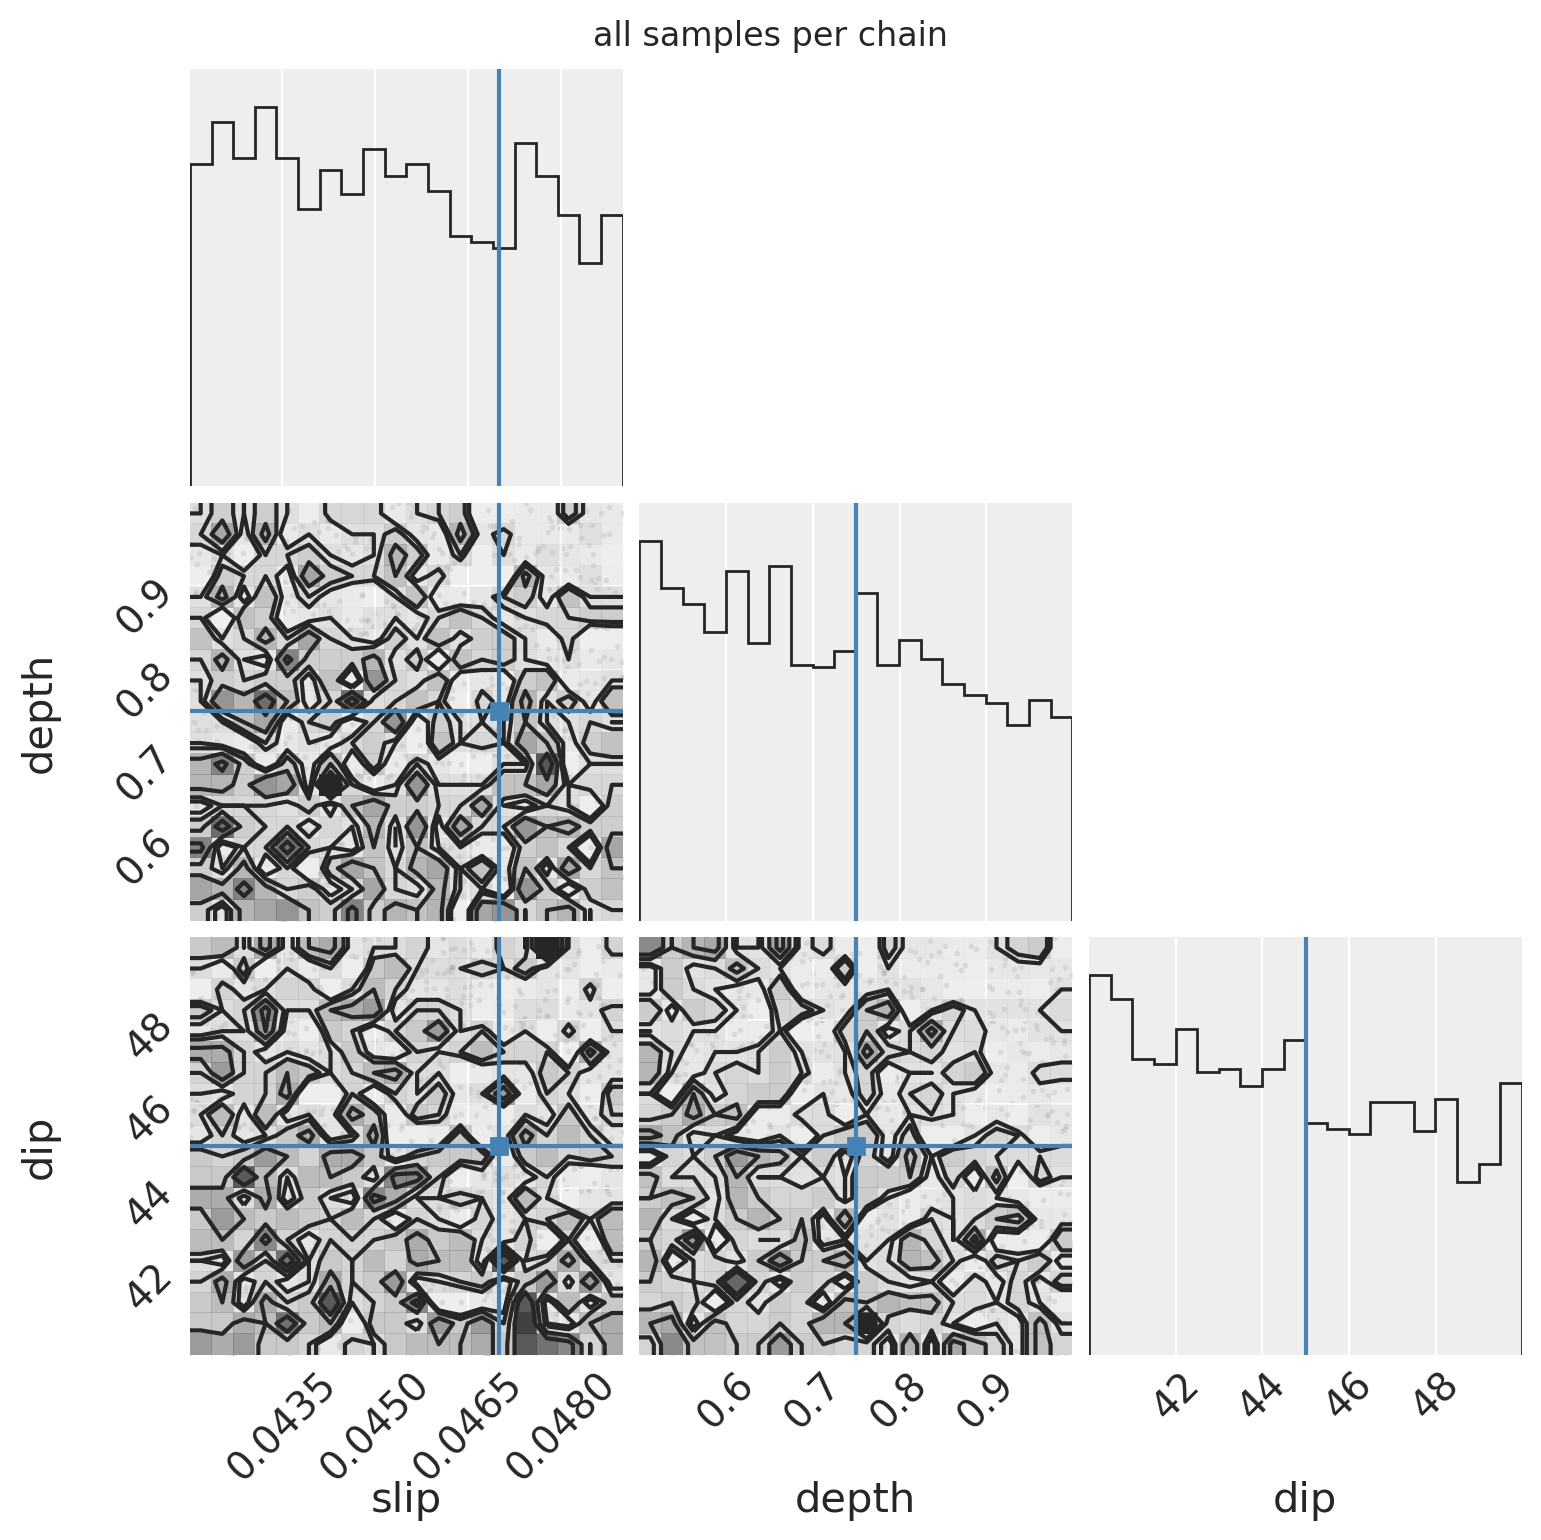

In [14]:
# https://espei.org/how-to/recipes/mcmc-corner-plots/
# https://corner.readthedocs.io/en/latest/pages/custom/

cnr = corner.corner(idata_no_grad, divergences=True, truths={"depth": 0.75, "dip": 45, "slip": 0.047})
cnr.suptitle("all samples per chain")
plt.show()

/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(


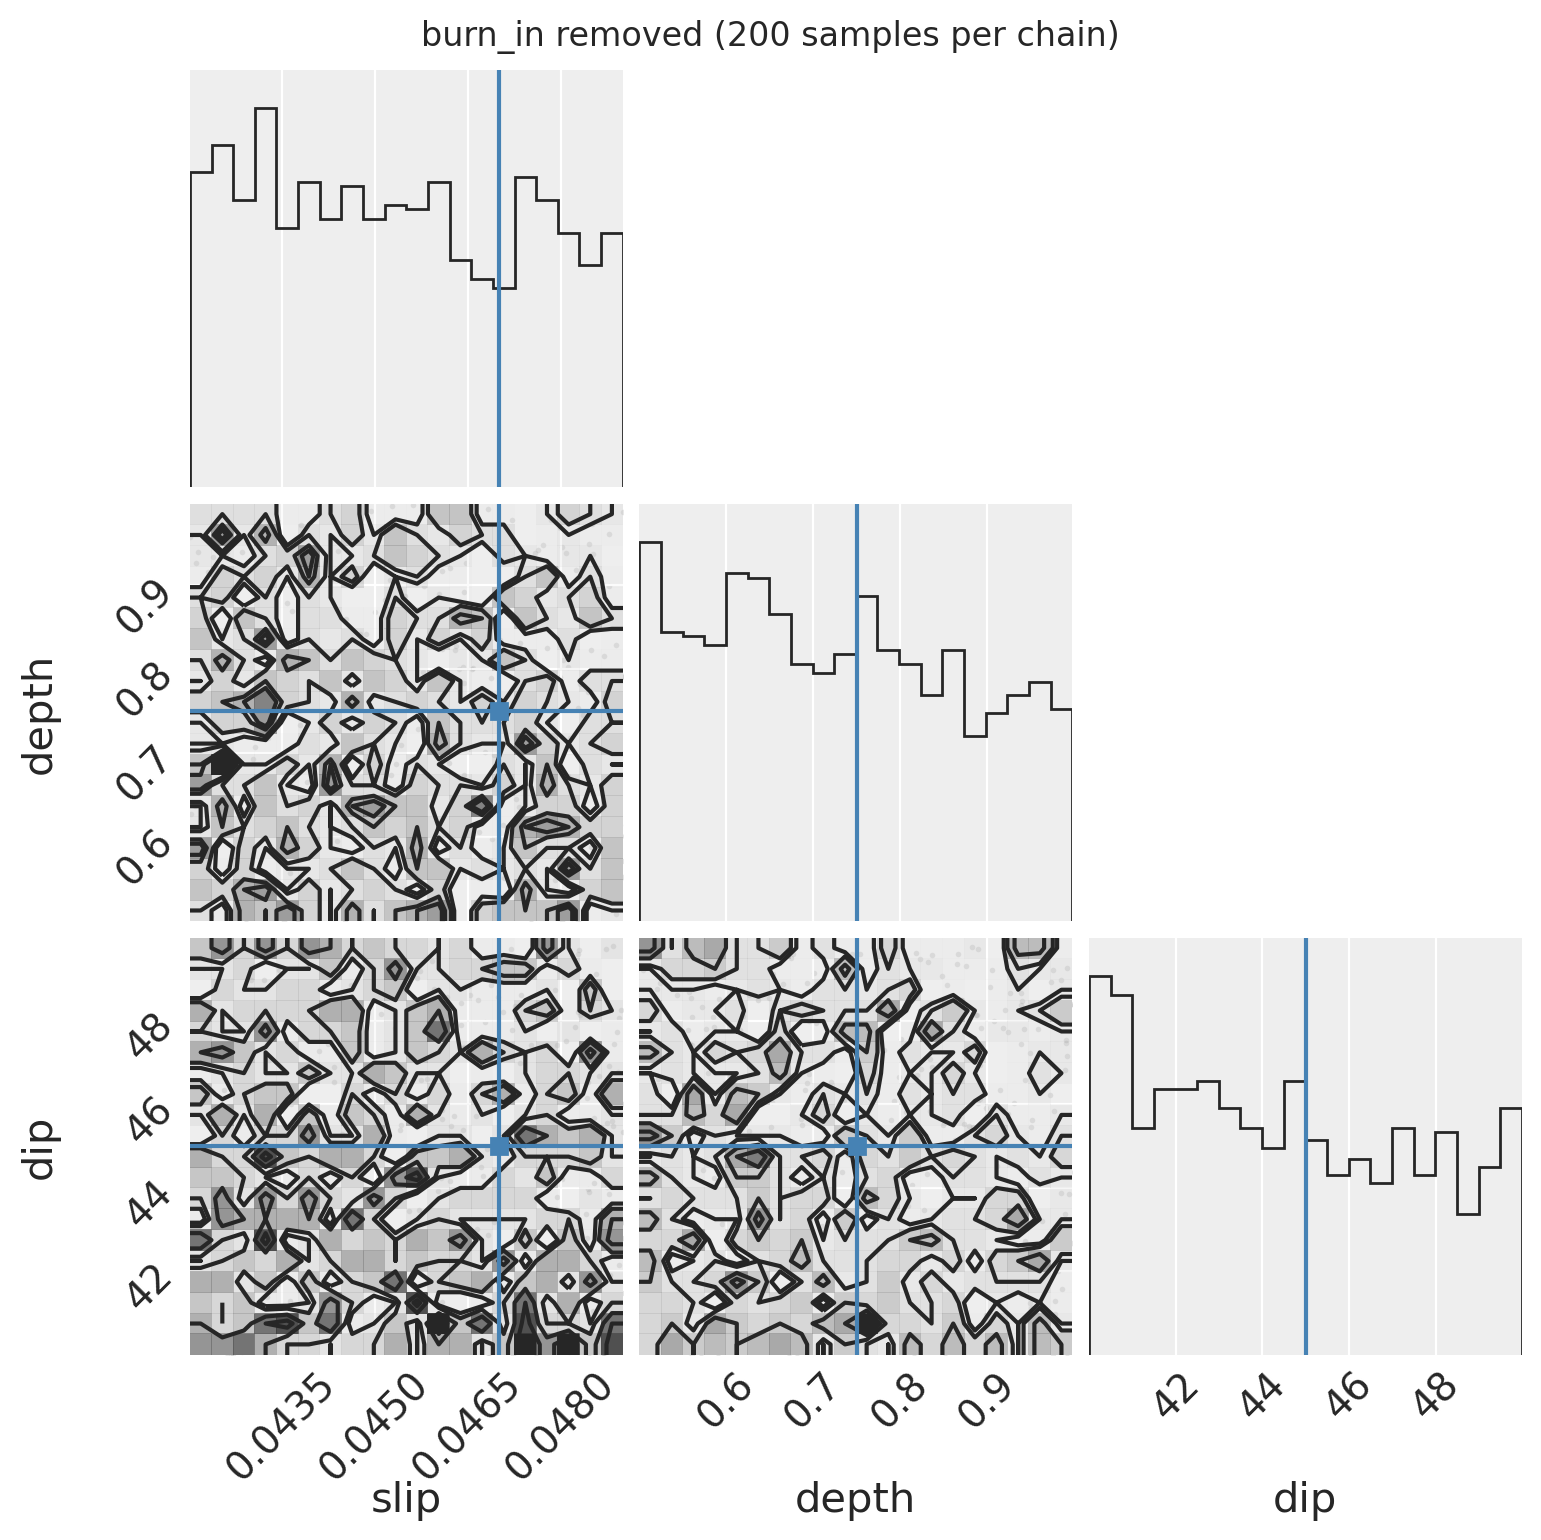

In [15]:
#fig = plt.figure(figsize=(8,8))
cnr = corner.corner(idata_sel, divergences=True, truths={"depth": 0.75, "dip": 45, "slip": 0.047})
cnr.suptitle("burn_in removed (200 samples per chain)")
plt.show()

In [17]:
def plot_corner(pymc_model, burn_in=False):
    chains = int(pymc_model.posterior.dims['chain'])
    draws = int(pymc_model.posterior.dims['draw'])
    tune = int(pymc_model.posterior.attrs['tuning_steps'])
    if burn_in:
        idata = pymc_model.sel(draw=slice(tune, None))
        cnr = corner.corner(idata, divergences=True)
        cnr.suptitle("{} draws, {} chains, {} samples per chain removed".format(draws, chains, tune))
        plt.close()
    else:
        cnr = corner.corner(pymc_model, divergences=True)
        cnr.suptitle("{} draws, {} chains, 0 samples per chain removed".format(draws, chains))
        plt.close()
    return cnr

/var/folders/88/kz2fv2rd77j28vvky2fwhj980000gr/T/ipykernel_81413/2616778343.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chains = int(pymc_model.posterior.dims['chain'])
/var/folders/88/kz2fv2rd77j28vvky2fwhj980000gr/T/ipykernel_81413/2616778343.py:3: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  draws = int(pymc_model.posterior.dims['draw'])
/opt/miniconda3/envs/elastic_py/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjus

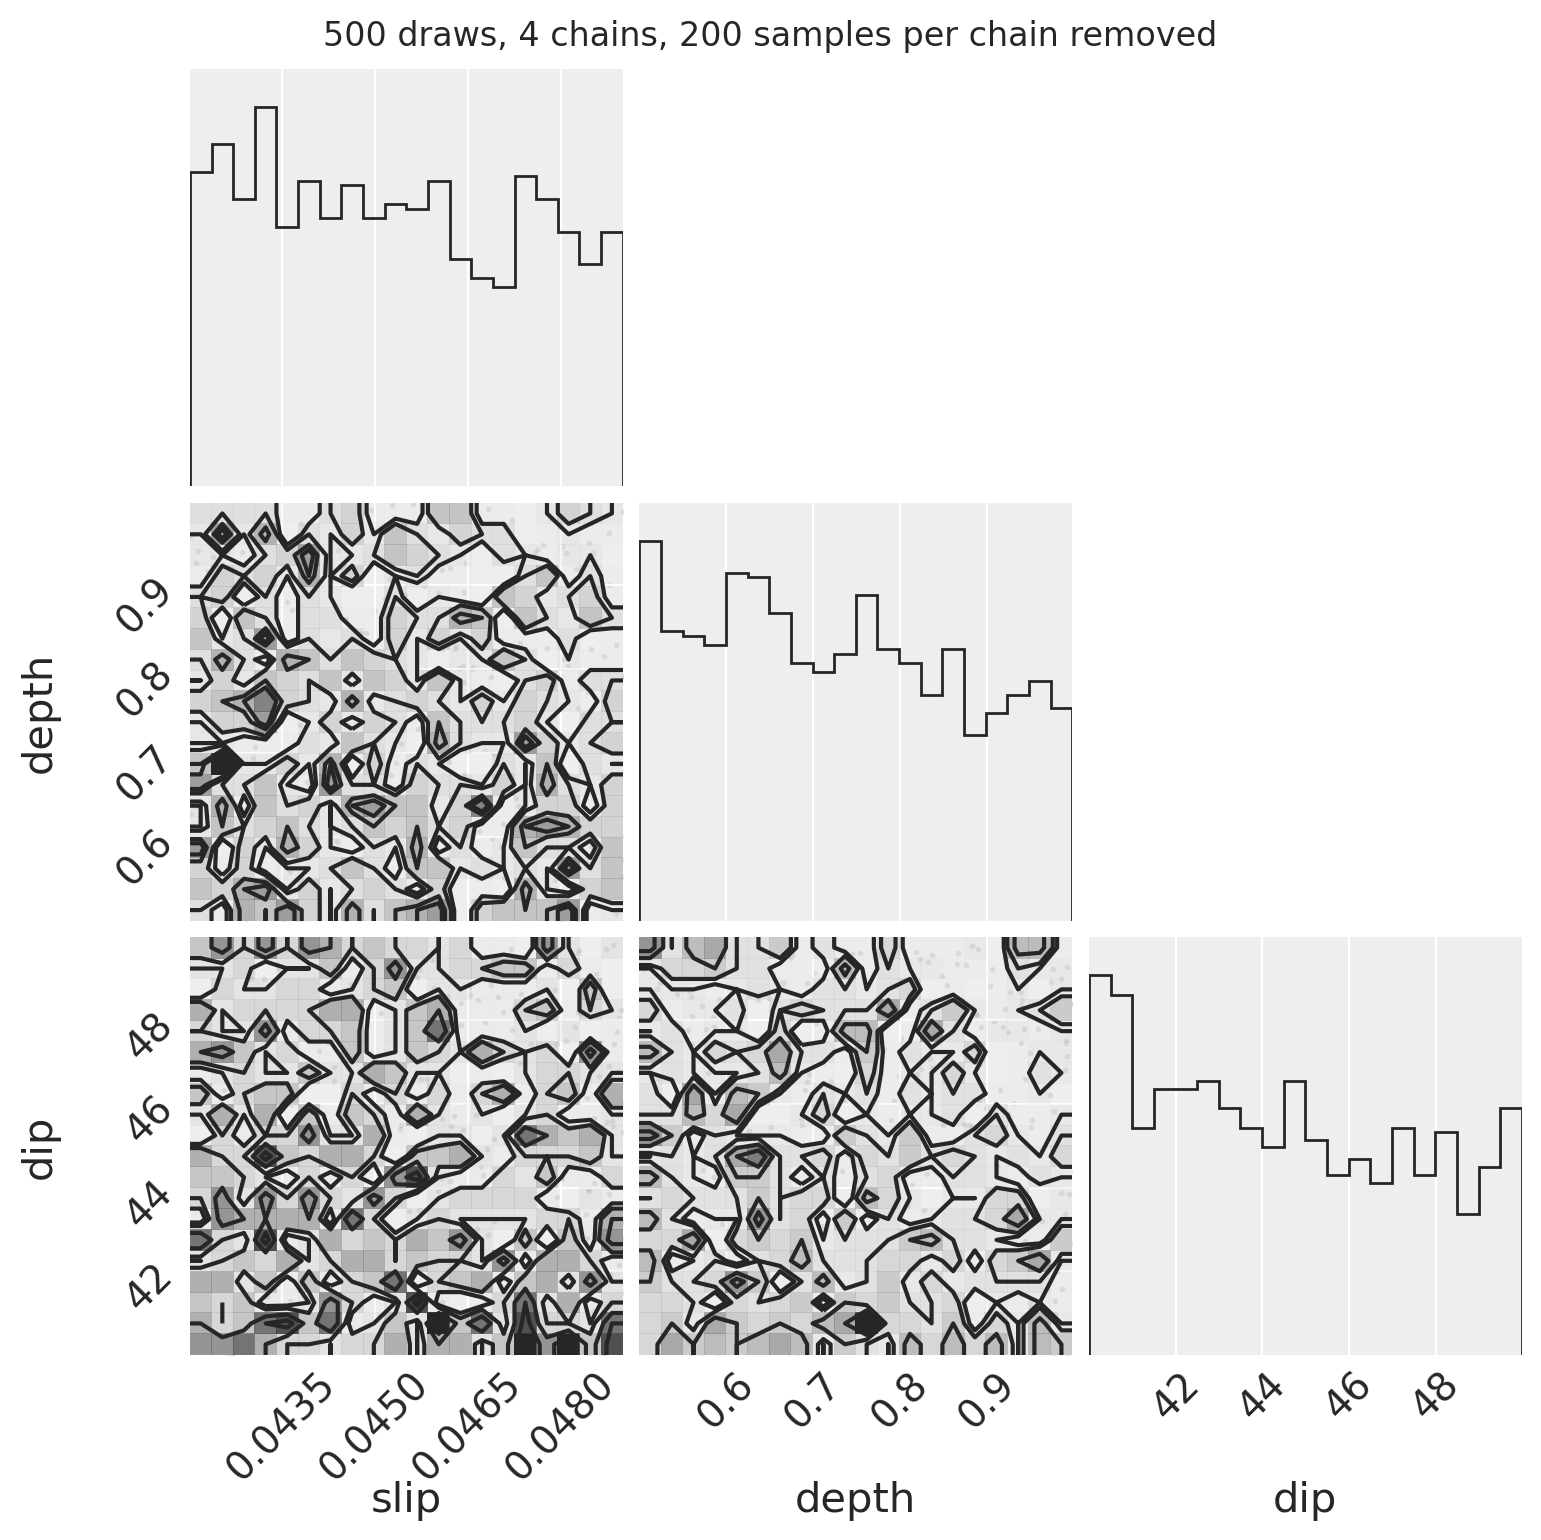

In [19]:
fig = plot_corner(idata_no_grad, burn_in=True)
fig

In [50]:
import numpy as np

from scipy.stats import truncnorm

import matplotlib.pyplot as plt

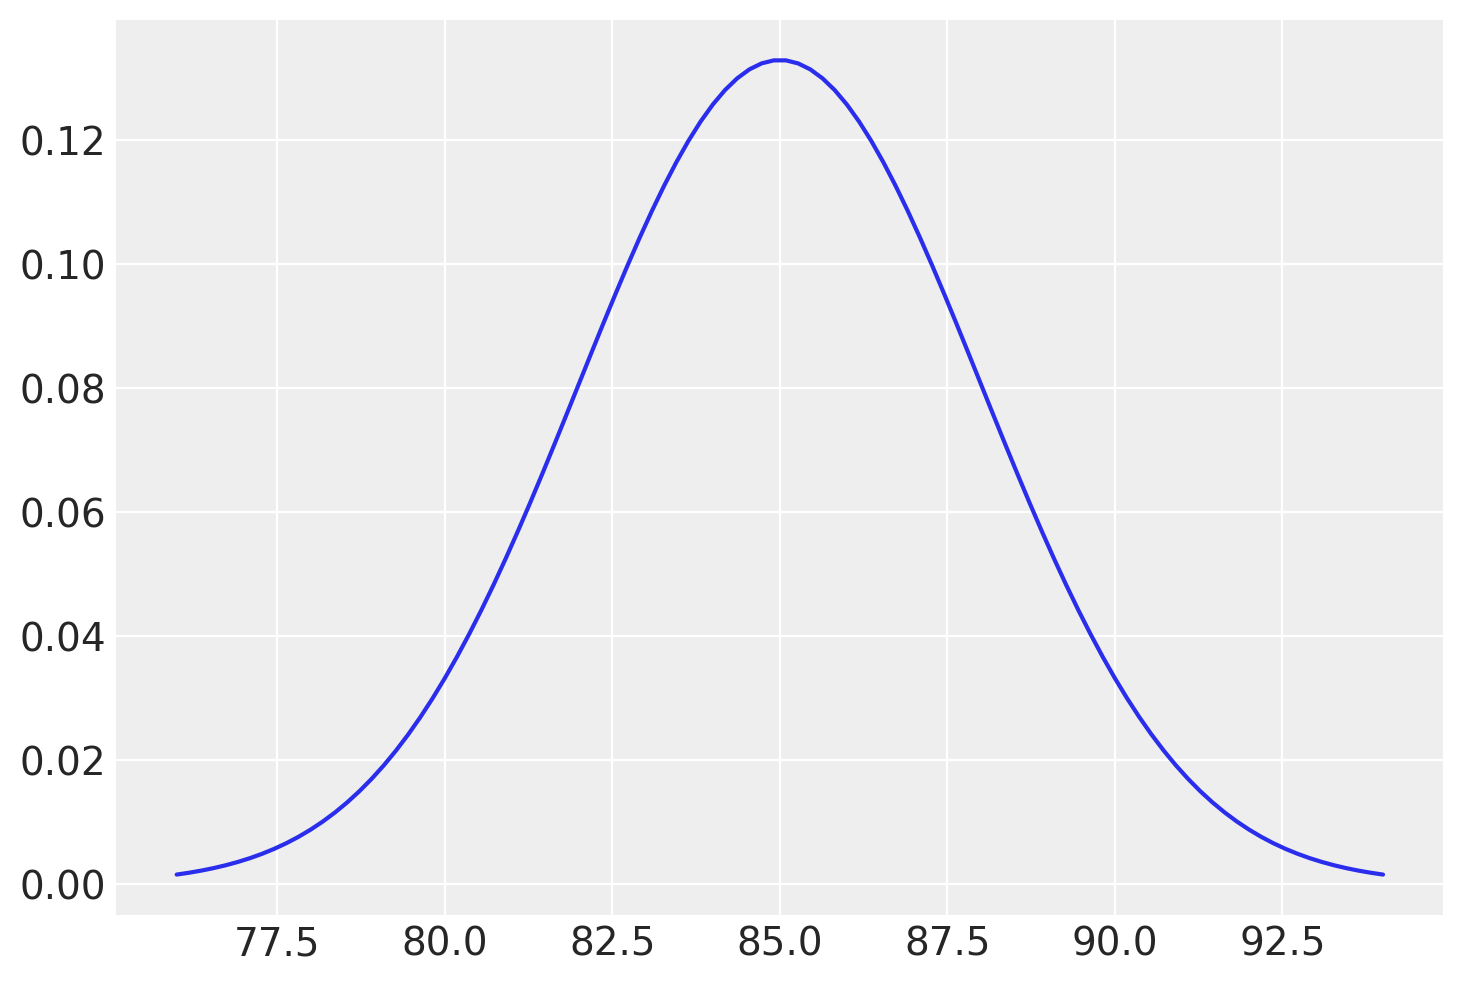

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 85
sigma = 3
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

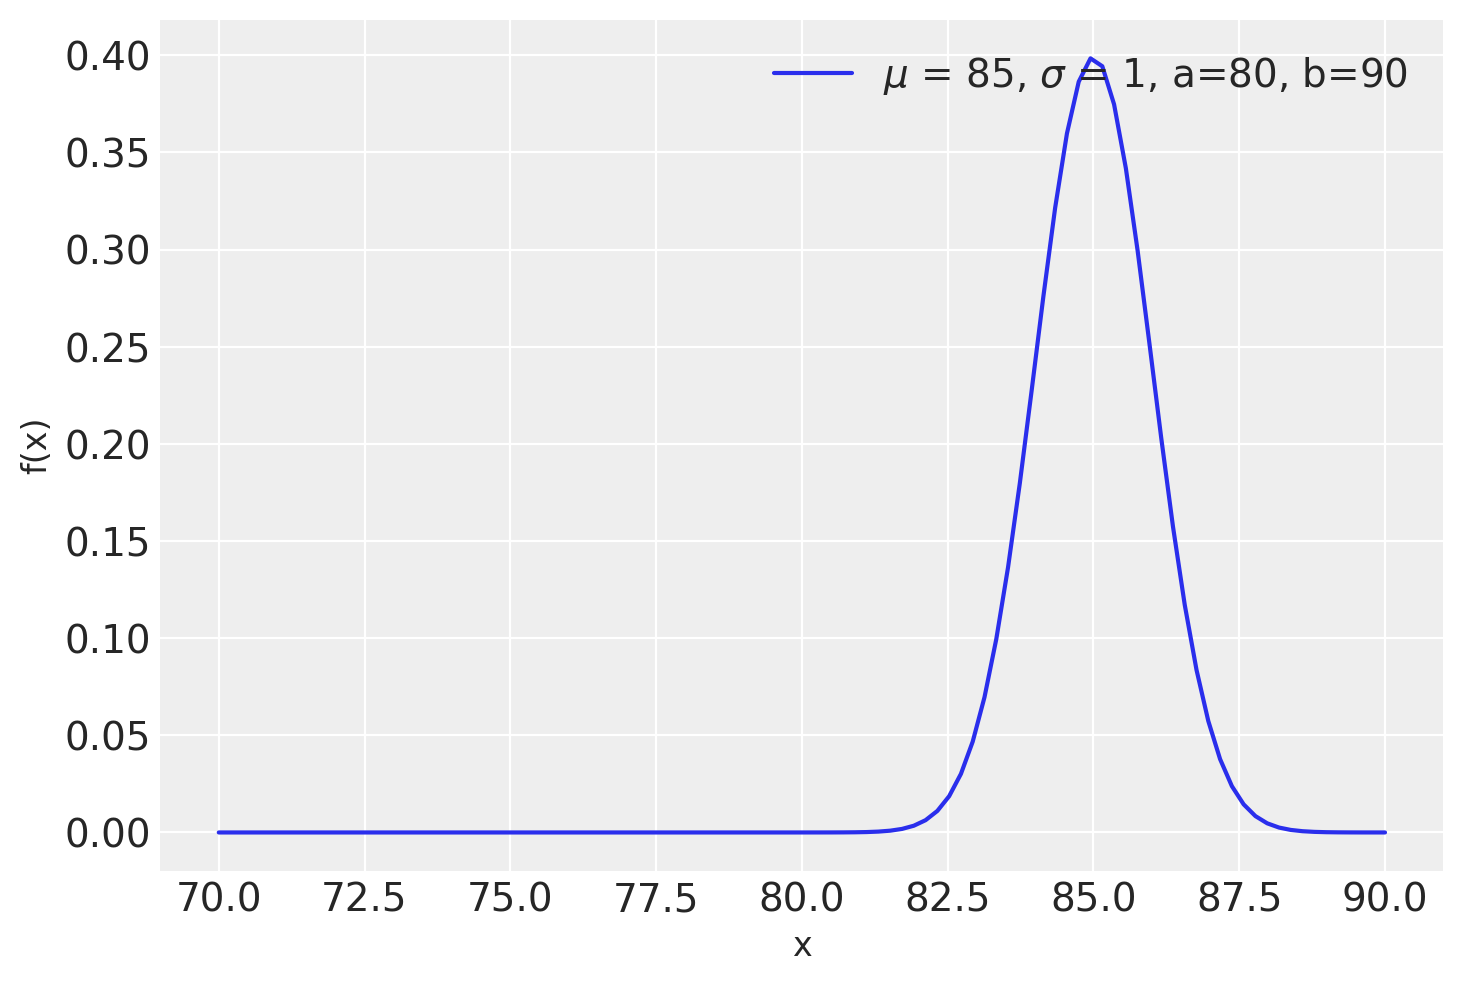

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import arviz as az
plt.style.use('arviz-darkgrid')
x = np.linspace(70, 90, 100)
mus = [85]
sigmas = [1]
a1 = [80]
b1 = [90]
for mu, sigma, a, b in zip(mus, sigmas,a1,b1):
    an, bn = (a - mu) / sigma, (b - mu) / sigma
    pdf = st.truncnorm.pdf(x, an,bn, loc=mu, scale=sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}, a={}, b={}'.format(mu, sigma, a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

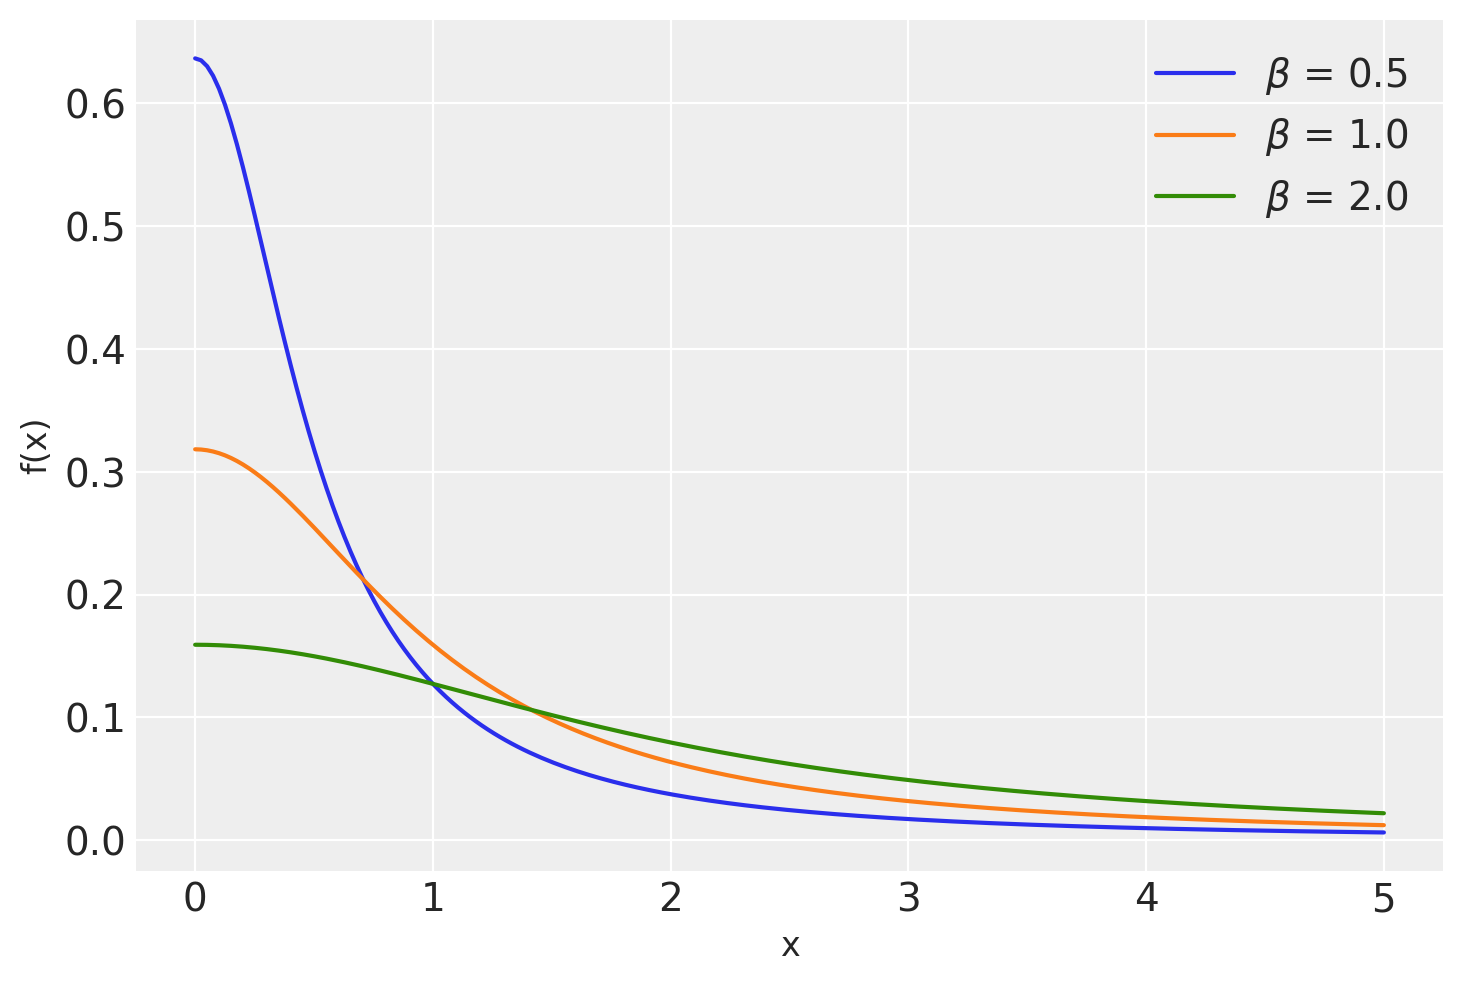

In [66]:
x = np.linspace(0, 5, 200)
for b in [0.5, 1.0, 2.0]:
    pdf = st.cauchy.pdf(x, scale=b)
    plt.plot(x, pdf, label=r'$\beta$ = {}'.format(b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [ ]:
"dip_mu": [
        85
    ],
    "dip_sigma": [
        1
    ],
    "dip_upper": [
        90
    ],
    "dip_lower": [
        80
    ],
    "dip_init": [
        85

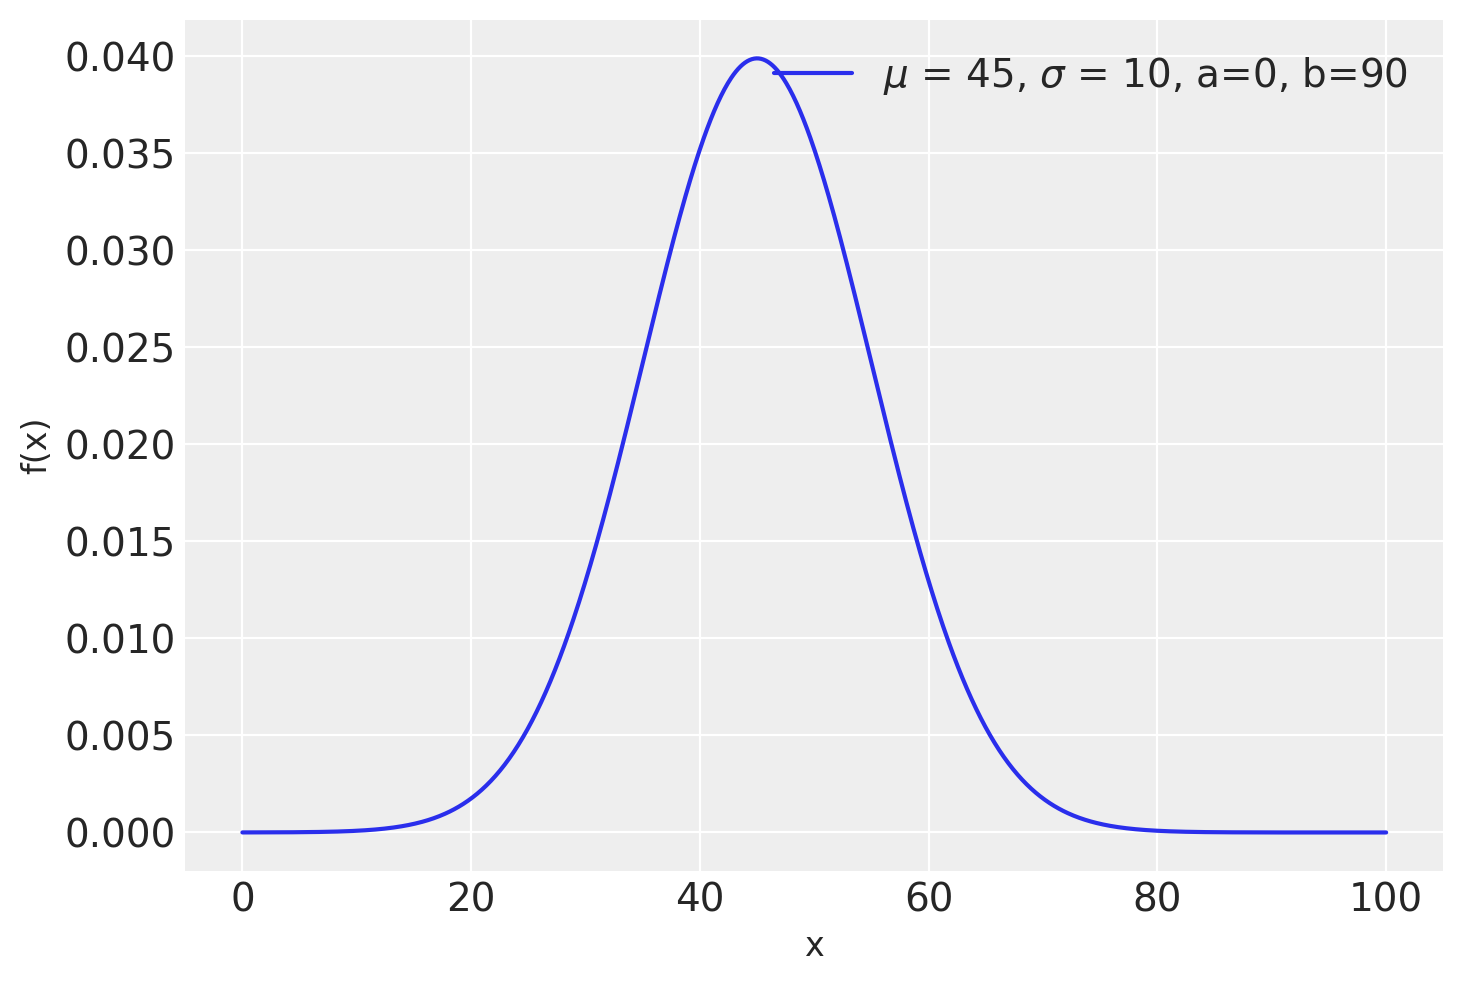

In [74]:
x = np.linspace(0, 100, 1000)
mus = [45]
sigmas = [10]
a1 = [0]
b1 = [90]
for mu, sigma, a, b in zip(mus, sigmas,a1,b1):
    an, bn = (a - mu) / sigma, (b - mu) / sigma
    pdf = st.truncnorm.pdf(x, an,bn, loc=mu, scale=sigma)
    plt.plot(x, pdf, label=r'$\mu$ = {}, $\sigma$ = {}, a={}, b={}'.format(mu, sigma, a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()